In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from dataclasses import dataclass
import empyrical

In [2]:
import os 
os.chdir("../")

In [3]:
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman'] 

#### 1.数据导入

In [4]:
# 净值、价格和成交量数据
lof_open = pd.read_csv("./Data/LOF开盘价.CSV",index_col = 0)
lof_close = pd.read_csv("./Data/LOF收盘价.CSV",index_col = 0)
lof_high = pd.read_csv("./Data/LOF最高价.CSV",index_col = 0)
lof_low = pd.read_csv("./Data/LOF最低价.CSV",index_col = 0)
lof_avg = pd.read_csv("./Data/LOF平均价.CSV",index_col = 0)
lof_nav = pd.read_csv("./Data/LOF复权净值.CSV",index_col = 0)
lof_volume = pd.read_csv("./Data/LOF成交量.CSV",index_col = 0)

# 将SZ,SH结尾的场内LOF转换成OF结尾的
lof_open.columns = lof_open.columns.map(lambda x:x[:6]+".OF")
lof_close.columns = lof_close.columns.map(lambda x:x[:6]+".OF")
lof_high.columns = lof_high.columns.map(lambda x:x[:6]+".OF")
lof_low.columns = lof_low.columns.map(lambda x:x[:6]+".OF")
lof_avg.columns = lof_avg.columns.map(lambda x:x[:6]+".OF")
lof_nav.columns = lof_nav.columns.map(lambda x:x[:6]+".OF")
lof_volume.columns = lof_volume.columns.map(lambda x:x[:6]+".OF")

lof_open.index = pd.to_datetime(lof_open.index)
lof_close.index = pd.to_datetime(lof_close.index)
lof_high.index = pd.to_datetime(lof_high.index)
lof_low.index = pd.to_datetime(lof_low.index)
lof_avg.index = pd.to_datetime(lof_avg.index)
lof_nav.index = pd.to_datetime(lof_nav.index)
lof_volume.index = pd.to_datetime(lof_volume.index)

In [5]:
filled_lof_close = lof_close.asfreq("D").ffill()

In [6]:
trade_date = pd.read_excel("./Data/TradeDate.xlsx") 
month_begin_end = pd.read_excel("./Data/MonthBeginEnd.xlsx")

trade_month_begin = month_begin_end.MONTH_START_TRADE.tolist()
trade_month_end = month_begin_end.MONTH_END_TRADE.tolist()

In [7]:
# 导入到期日数据
maturity_period = pd.read_excel("./Output/MaturePeriod.xlsx",index_col = 0)

#### 2.计算年化折价率

In [8]:
discount_ratio = lof_close/lof_nav-1

annual_discount_ratio = discount_ratio*365/np.transpose(maturity_period)
annual_discount_ratio.dropna(how = "all",axis = 1,inplace = True)

In [9]:
annual_discount_ratio.index = pd.to_datetime(annual_discount_ratio.index)
filled_annual_discount_ratio = annual_discount_ratio.asfreq("D").ffill()

#### 3.构建买卖信号

In [10]:
start_date = pd.to_datetime("2013-12-31")
end_date = pd.to_datetime("2022-03-25")

In [11]:
@dataclass
class FundObject:
    vt_symbol:str = ""
    buy_price:float = 0.0
    volume:float = 0.0
    
    def __post_init__(self):
        self.price:float = self.buy_price
        self.last_price:float = self.price
        self.pnl:float = (self.price - self.buy_price)*self.volume
        self.daily_pnl:float = (self.price - self.last_price)*self.volume
        self.status:str = "HOLDING"
        self.discount_pct:float = 0.0

In [12]:
# 记录仓位变化
'''account'''
capital:float = 300000.0 # 本金
available:float = capital
in_position_lof:dict = {}
backtest_result:pd.DataFrame = pd.DataFrame(columns = ["ACCOUNT_BALANCE"])
'''variables'''

'''paramaters'''
upper_year:int = 365 # 距离下次开放最远的购买时间
lower_year:int = 90 # 距离下次开放最近的购买时间

single_position_limit:float = 0.1 # 个基最大的仓位限制
single_buy_limit:float = 0.01 # 每次购买2%成的仓位

profit_stop_upper:float = 0.15 # 个基止盈
profit_stop_lower:float = 0.05  # 个基止损

adding_percent:float = 0.98 # 当购买价格小于或等于该值倍数时才能加仓平摊成本
discount_ub:float = -0.075 # 买入目标年化折价率上界
discount_lb:float = -0.12 # 买入目标年化折价率上界
    
buy_cost:float = 0.003
sell_cost:float = 0.003

In [13]:
for date in trade_date.loc[(trade_date.DATE>=start_date)&(trade_date.DATE<=end_date)].DATE:
    """"""
    print(f"processing {date}")
    if date in trade_month_end:
        # buy condition: discount ratio in [0,0.06]
        daily_discount_lof = discount_ratio.loc[date,(discount_ratio.loc[date,:]<=0)&(discount_ratio.loc[date,:]>=discount_ub)].dropna()
        in_pool_lof = daily_discount_lof.index.tolist() # have lof at the end of months

        # adjust and clear
        for to_sell_lof in in_position_lof.keys():
            price = filled_lof_close.at[date,to_sell_lof]
            in_position_lof[to_sell_lof].last_price = in_position_lof[to_sell_lof].price
            in_position_lof[to_sell_lof].price = price
            in_position_lof[to_sell_lof].pnl = (in_position_lof[to_sell_lof].price - \
                                                in_position_lof[to_sell_lof].buy_price)*in_position_lof[to_sell_lof].volume
            in_position_lof[to_sell_lof].daily_pnl = (in_position_lof[to_sell_lof].price - \
                                                      in_position_lof[to_sell_lof].last_price)*in_position_lof[to_sell_lof].volume
            in_position_lof[to_sell_lof].discount_pct = discount_ratio.at[date,to_sell_lof]
            
            # sell
            if to_sell_lof not in in_pool_lof:
                sell_price = filled_lof_close.at[date,to_sell_lof]
                print(f"sell {to_sell_lof} at {sell_price}")
                in_position_lof[to_sell_lof].status = "SOLD"
            
    elif date in trade_month_begin: # buy at the beginning of months
        # buy
        for to_buy_lof in in_pool_lof:
            if to_buy_lof not in in_position_lof.keys():
                for after in range(1,10): # ten days to ask price 
                    try:
                        trade_volume = lof_volume.loc[date:,to_buy_lof].iloc[after] # deal if there is volume
                    except IndexError: # no deal after 5 trade days
                        break # cancel ask
                    if pd.isnull(trade_volume) or trade_volume == 0: # no trade volume in the day
                        continue # ask on the next day
                    else:
                        buy_price = lof_avg.loc[date:,to_buy_lof].iloc[after]
                        buy_date = lof_avg.loc[date:,[to_buy_lof]].iloc[after].name
                        buy_volume = min(capital/len(in_pool_lof)/(buy_price*(1+buy_cost)),trade_volume)
                        if buy_price*buy_volume*(1+buy_cost)<=available: # enough money
                            in_position_lof[to_buy_lof] = FundObject(
                                vt_symbol = to_buy_lof,
                                buy_price = buy_price, # today's pnl is moved to the next day
                                volume = buy_volume,
                            )
                            print(f"buy {to_buy_lof}|buy date:{buy_date}|buy price:{buy_price}|buy volume:{buy_volume}")
                            available -= in_position_lof[to_buy_lof].volume*in_position_lof[to_buy_lof].price*(1+buy_cost)
                            capital -= in_position_lof[to_buy_lof].volume*in_position_lof[to_buy_lof].price*buy_cost
                            break # dealed
                        
                        elif available >= 1000: # not enough money
                            buy_volume = min((available-1)/(buy_price*(1+buy_cost)),trade_volume)
                            in_position_lof[to_buy_lof] = FundObject(
                                vt_symbol = to_buy_lof,
                                buy_price = buy_price,
                                volume = buy_volume,
                            )
                            print(f"scaled buy {to_buy_lof}|buy price:{buy_price}|buy volume:{buy_volume}")
                            available -= in_position_lof[to_buy_lof].volume*in_position_lof[to_buy_lof].price*(1+buy_cost)
                            capital -= in_position_lof[to_buy_lof].volume*in_position_lof[to_buy_lof].price*buy_cost
                            break # dealed
                            
            # else in position, adjust position, adjust buy price and volume
            else:
                # update and buy
                price = filled_lof_close.at[date,to_buy_lof]
                in_position_lof[to_buy_lof].last_price = in_position_lof[to_buy_lof].price
                in_position_lof[to_buy_lof].price = price
                in_position_lof[to_buy_lof].pnl = (in_position_lof[to_buy_lof].price - \
                                                   in_position_lof[to_buy_lof].buy_price)*in_position_lof[to_buy_lof].volume
                in_position_lof[to_buy_lof].daily_pnl = (in_position_lof[to_buy_lof].price - \
                                                         in_position_lof[to_buy_lof].last_price)*in_position_lof[to_buy_lof].volume
                
                buy_price = filled_lof_close.at[date,to_buy_lof]
                buy_volume = capital/len(in_pool_lof)/(buy_price*(1+buy_cost))
                to_buy_volume = buy_volume - in_position_lof[to_buy_lof].volume
                
                if to_buy_volume<=0: # sell those over weight
                    print(f"sell adjust {to_buy_lof}|buy date:{date}|buy price:{buy_price}|volume from {in_position_lof[to_buy_lof].volume} to {buy_volume}")
                    available -= buy_price*to_buy_volume*(1-sell_cost)
                    capital += buy_price*to_buy_volume*sell_cost # negative + negative = positive
                    in_position_lof[to_buy_lof].volume += to_buy_volume
                
                elif buy_price*to_buy_volume*(1+buy_cost)<=available: # add those lower than the weight
                    for after in range(1,10): # 5 days to ask price 
                        try:
                            trade_volume = lof_volume.loc[date:,to_buy_lof].iloc[after] # deal if there is volume
                        except IndexError: # no deal after 5 trade days
                            break # cancel ask
                        if pd.isnull(trade_volume) or trade_volume == 0: # no trade volume in the day
                            continue # ask on the next day
                        else:
                            buy_price = lof_avg.loc[date:,to_buy_lof].iloc[after]
                            buy_date = lof_avg.loc[date:,[to_buy_lof]].iloc[after].name
                            buy_volume = min(to_buy_volume,trade_volume)
                            break
                    
                    # if ten days no trade, next lof
                    if pd.isnull(trade_volume) or trade_volume == 0:
                        continue
                    print(f"buy adjust {to_buy_lof}|buy date:{date}|buy price:{buy_price}|volume from {in_position_lof[to_buy_lof].volume} to {buy_volume}")
                    adjusted_buy_price = (buy_price*buy_volume+in_position_lof[to_buy_lof].price*\
                                          in_position_lof[to_buy_lof].volume)/(in_position_lof[to_buy_lof].volume+buy_volume)
                    in_position_lof[to_buy_lof].buy_price = adjusted_buy_price
                    in_position_lof[to_buy_lof].volume += buy_volume
                    available -= buy_price*buy_volume*(1+buy_cost)
                    capital -= buy_volume*(buy_price - filled_lof_close.at[date,to_buy_lof])
                    capital -= buy_volume*buy_price*buy_cost
                
                elif buy_price*to_buy_volume*(1+buy_cost)>available: # not enough money
                    print(f"Not Enough Money in Account:{available}")
                       
    else:
        for to_adjust_lof in in_position_lof.keys():
            price = filled_lof_close.at[date,to_adjust_lof]
            in_position_lof[to_adjust_lof].last_price = in_position_lof[to_adjust_lof].price
            in_position_lof[to_adjust_lof].price = price
            in_position_lof[to_adjust_lof].pnl = (in_position_lof[to_adjust_lof].price - \
                                                  in_position_lof[to_adjust_lof].buy_price)*in_position_lof[to_adjust_lof].volume
            in_position_lof[to_adjust_lof].daily_pnl = (in_position_lof[to_adjust_lof].price - \
                                                        in_position_lof[to_adjust_lof].last_price)*in_position_lof[to_adjust_lof].volume
    
    # daily profit and loss
    for to_settle_lof in list(in_position_lof.keys()):
        capital += in_position_lof[to_settle_lof].daily_pnl
        # close->open, sell
        if maturity_period.at[to_settle_lof,date] == 0: 
            print(f"sell {to_settle_lof}|sell date:{date}|sell price:{in_position_lof[to_settle_lof].price}")
            in_position_lof[to_settle_lof].status = "SOLD"
        
        # profit and loss stop
        # profit stop
        if in_position_lof[to_settle_lof].price/in_position_lof[to_settle_lof].buy_price-1 >= profit_stop_upper:
            print(f"profit {to_settle_lof}|sell date:{date}|sell price:{in_position_lof[to_settle_lof].price}")
            in_position_lof[to_settle_lof].status = "SOLD"
        # loss stop
        elif in_position_lof[to_settle_lof].price/in_position_lof[to_settle_lof].buy_price-1 <= -profit_stop_lower:
            print(f"loss {to_settle_lof}|sell date:{date}|sell price:{in_position_lof[to_settle_lof].price}")
            in_position_lof[to_settle_lof].status = "SOLD"
        
        # cancel sold records
        if in_position_lof[to_settle_lof].status == "SOLD":
            available += in_position_lof[to_settle_lof].price*in_position_lof[to_settle_lof].volume*(1-sell_cost) # release money
            capital -= in_position_lof[to_settle_lof].price*in_position_lof[to_settle_lof].volume*sell_cost # sell cost
            del in_position_lof[to_settle_lof]
    backtest_result.loc[date,"ACCOUNT_BALANCE"] = capital

processing 2013-12-31 00:00:00
processing 2014-01-02 00:00:00
buy 160105.OF|buy date:2014-01-03 00:00:00|buy price:2.925815477|buy volume:1481.5772410005102
buy 160106.OF|buy date:2014-01-03 00:00:00|buy price:4.042610752|buy volume:1072.2362307973444
buy 160119.OF|buy date:2014-01-03 00:00:00|buy price:0.994893697|buy volume:4356.692408179733
buy 160125.OF|buy date:2014-01-09 00:00:00|buy price:1.1207|buy volume:3867.4559883745073
buy 160128.OF|buy date:2014-01-03 00:00:00|buy price:0.9844|buy volume:4402.752990472947
buy 160212.OF|buy date:2014-01-03 00:00:00|buy price:0.9124|buy volume:4749.980457711742
buy 160215.OF|buy date:2014-01-07 00:00:00|buy price:0.83|buy volume:100.0
buy 160416.OF|buy date:2014-01-08 00:00:00|buy price:1.086796584|buy volume:3987.5821928907376
buy 160515.OF|buy date:2014-01-03 00:00:00|buy price:0.9447|buy volume:1600.0
buy 160607.OF|buy date:2014-01-03 00:00:00|buy price:2.524878425|buy volume:1716.2954395300667
buy 160610.OF|buy date:2014-01-03 00:00:00|

buy 161119.OF|buy date:2014-02-11 00:00:00|buy price:1.044|buy volume:2000.0
buy adjust 161216.OF|buy date:2014-02-07 00:00:00|buy price:1.11883411|volume from 3841.1224694706393 to 38.46184338768853
buy 161217.OF|buy date:2014-02-10 00:00:00|buy price:0.5093|buy volume:8526.246053254084
buy adjust 161219.OF|buy date:2014-02-07 00:00:00|buy price:1.446508|volume from 1562.0 to 1284.4299435504981
buy adjust 161607.OF|buy date:2014-02-07 00:00:00|buy price:2.195778463|volume from 1909.5785467118646 to 100.60951917793818
sell adjust 161614.OF|buy date:2014-02-07 00:00:00|buy price:1.0613|volume from 4152.451419259031 to 4092.673086393684
sell adjust 161706.OF|buy date:2014-02-07 00:00:00|buy price:3.5648|volume from 1249.703790641286 to 1218.4557889530415
buy adjust 161713.OF|buy date:2014-02-07 00:00:00|buy price:1.1573117|volume from 3734.306293530928 to 38.09805576324379
buy 161820.OF|buy date:2014-02-10 00:00:00|buy price:1.0095|buy volume:4302.665876315122
buy adjust 161907.OF|buy da

buy adjust 160515.OF|buy date:2014-04-01 00:00:00|buy price:0.977573969|volume from 3702.0 to 2000.0
buy 160607.OF|buy date:2014-04-02 00:00:00|buy price:2.452794262|buy volume:2376.470226337371
buy 160616.OF|buy date:2014-04-02 00:00:00|buy price:0.798|buy volume:7304.073532116988
buy adjust 160617.OF|buy date:2014-04-01 00:00:00|buy price:1.154059469|volume from 4719.2079704635125 to 359.48568789621095
buy adjust 160706.OF|buy date:2014-04-01 00:00:00|buy price:2.086244975|volume from 2573.7123523903965 to 226.97919802218712
buy 160716.OF|buy date:2014-04-02 00:00:00|buy price:0.5942|buy volume:9808.461917617484
buy adjust 160717.OF|buy date:2014-04-01 00:00:00|buy price:0.7265|volume from 7955.8090448497815 to 334.1571888392182
buy adjust 160916.OF|buy date:2014-04-01 00:00:00|buy price:0.804131338|volume from 6747.377151211684 to 500.97920555574274
buy adjust 161005.OF|buy date:2014-04-01 00:00:00|buy price:4.757515154|volume from 1121.1021904393265 to 117.66441065536719
buy 161010

processing 2014-06-09 00:00:00
processing 2014-06-10 00:00:00
processing 2014-06-11 00:00:00
processing 2014-06-12 00:00:00
processing 2014-06-13 00:00:00
profit 166009.OF|sell date:2014-06-13 00:00:00|sell price:1.396
profit 163821.OF|sell date:2014-06-13 00:00:00|sell price:1.06
processing 2014-06-16 00:00:00
sell 165311.OF|sell date:2014-06-16 00:00:00|sell price:1.2087
processing 2014-06-17 00:00:00
processing 2014-06-18 00:00:00
processing 2014-06-19 00:00:00
processing 2014-06-20 00:00:00
processing 2014-06-23 00:00:00
processing 2014-06-24 00:00:00
processing 2014-06-25 00:00:00
processing 2014-06-26 00:00:00
processing 2014-06-27 00:00:00
processing 2014-06-30 00:00:00
sell 160125.OF at 1.2141
sell 161115.OF at 1.1552
sell 161217.OF at 0.494
sell 162411.OF at 1.34
sell 163412.OF at 1.76
sell 165509.OF at 1.1458
processing 2014-07-01 00:00:00
sell adjust 160105.OF|buy date:2014-07-01 00:00:00|buy price:2.9118|volume from 1710.1311634360766 to 1518.0541314655197
sell adjust 16010

sell adjust 161907.OF|buy date:2014-08-01 00:00:00|buy price:0.877|volume from 5621.732731140552 to 5048.534968073977
sell adjust 161908.OF|buy date:2014-08-01 00:00:00|buy price:1.0059|volume from 4418.141306436758 to 4401.574699196789
sell adjust 162006.OF|buy date:2014-08-01 00:00:00|buy price:3.5981|volume from 1281.946700818626 to 1230.5225779996772
buy adjust 162207.OF|buy date:2014-08-01 00:00:00|buy price:2.27830227|volume from 1910.020468580711 to 34.35417159862436
sell adjust 162703.OF|buy date:2014-08-01 00:00:00|buy price:3.6407|volume from 1267.241927054018 to 1216.1209701164908
sell adjust 162711.OF|buy date:2014-08-01 00:00:00|buy price:0.931|volume from 5090.1083322149625 to 4755.66463519389
sell adjust 162715.OF|buy date:2014-08-01 00:00:00|buy price:0.949|volume from 4823.32360678123 to 4665.448533573184
buy 163001.OF|buy date:2014-08-04 00:00:00|buy price:0.7662|buy volume:5778.523031490179
buy adjust 163210.OF|buy date:2014-08-01 00:00:00|buy price:0.995|volume from

buy 164808.OF|buy date:2014-09-02 00:00:00|buy price:1.349227281|buy volume:3402.747625560188
buy adjust 164810.OF|buy date:2014-09-01 00:00:00|buy price:1.065353777|volume from 4196.668340352369 to 99.09637819506679
buy adjust 164902.OF|buy date:2014-09-01 00:00:00|buy price:1.2924|volume from 3806.9768198793818 to 87.89377200495574
buy adjust 165309.OF|buy date:2014-09-01 00:00:00|buy price:0.7158|volume from 6265.871074856514 to 209.07501163059715
buy 165311.OF|buy date:2014-09-02 00:00:00|buy price:1.226141076|buy volume:3744.030944840056
buy adjust 165313.OF|buy date:2014-09-01 00:00:00|buy price:0.983361315|volume from 4545.975003120426 to 133.44800914494044
buy adjust 165509.OF|buy date:2014-09-01 00:00:00|buy price:1.1773|volume from 3823.4008943437443 to 83.41091813862022
buy 165510.OF|buy date:2014-09-03 00:00:00|buy price:0.845|buy volume:2400.0
sell adjust 165516.OF|buy date:2014-09-01 00:00:00|buy price:1.446|volume from 3555.7091069701123 to 3174.557605067341
sell adjust 

buy adjust 164702.OF|buy date:2014-10-08 00:00:00|buy price:1.098565198|volume from 4218.187307556639 to 439.365677386274
buy adjust 164810.OF|buy date:2014-10-08 00:00:00|buy price:1.076|volume from 4295.764718547436 to 438.4179875516511
buy adjust 165309.OF|buy date:2014-10-08 00:00:00|buy price:0.7408|volume from 6474.946086487111 to 449.16000459992847
buy 165311.OF|buy date:2014-10-10 00:00:00|buy price:1.22980878|buy volume:4138.1739905457625
buy adjust 165313.OF|buy date:2014-10-08 00:00:00|buy price:0.997422136|volume from 4679.423012265366 to 436.6205434336962
buy 165508.OF|buy date:2014-10-09 00:00:00|buy price:1.1421|buy volume:4455.7308945425
buy adjust 165509.OF|buy date:2014-10-08 00:00:00|buy price:1.198150665|volume from 3906.8118124823645 to 350.7652334573372
buy 165512.OF|buy date:2014-10-09 00:00:00|buy price:1.4475|buy volume:3515.4548331316155
buy 165516.OF|buy date:2014-10-09 00:00:00|buy price:1.4927|buy volume:3408.847534001516
buy adjust 166001.OF|buy date:2014-

processing 2014-11-24 00:00:00
processing 2014-11-25 00:00:00
processing 2014-11-26 00:00:00
profit 164105.OF|sell date:2014-11-26 00:00:00|sell price:1.4239
processing 2014-11-27 00:00:00
profit 163412.OF|sell date:2014-11-27 00:00:00|sell price:2.171
processing 2014-11-28 00:00:00
sell 160613.OF at 1.6607
sell 161010.OF at 1.5676
sell 161216.OF at 1.3723
sell 165311.OF at 1.3154
sell 165508.OF at 1.36
sell 160125.OF at 1.1935
sell 160717.OF at 0.81
sell 161217.OF at 0.6
sell 164606.OF at 1.1119
sell 165510.OF at 0.809
profit 160716.OF|sell date:2014-11-28 00:00:00|sell price:0.796
profit 165508.OF|sell date:2014-11-28 00:00:00|sell price:1.36
sell 165510.OF|sell date:2014-11-28 00:00:00|sell price:0.809
processing 2014-12-01 00:00:00
buy adjust 160105.OF|buy date:2014-12-01 00:00:00|buy price:3.66401776|volume from 1423.6780269293054 to 141.9113417546091
buy adjust 160106.OF|buy date:2014-12-01 00:00:00|buy price:4.893038041|volume from 1058.68337553189 to 103.49828241940486
buy adju

processing 2014-12-31 00:00:00
sell 163409.OF at 1.899
sell 164808.OF at 1.4659
sell 166008.OF at 1.2926
sell 166006.OF at 0.92
profit 165313.OF|sell date:2014-12-31 00:00:00|sell price:1.2326
profit 163409.OF|sell date:2014-12-31 00:00:00|sell price:1.899
processing 2015-01-05 00:00:00
buy adjust 160105.OF|buy date:2015-01-05 00:00:00|buy price:3.85415065|volume from 1565.5893686839145 to 169.83168476987134
buy adjust 160106.OF|buy date:2015-01-05 00:00:00|buy price:5.15949579|volume from 1162.181657951295 to 109.25264751630584
buy adjust 160119.OF|buy date:2015-01-05 00:00:00|buy price:1.382853401|volume from 4251.219494239759 to 566.1078677284631
buy 160125.OF|buy date:2015-01-06 00:00:00|buy price:1.199140561|buy volume:5526.930117664889
buy adjust 160128.OF|buy date:2015-01-05 00:00:00|buy price:1.16305916|volume from 4800.7770109859375 to 846.1317276645286
buy adjust 160212.OF|buy date:2015-01-05 00:00:00|buy price:1.0784|volume from 5476.210329536462 to 677.2885785931685
buy adj

buy 160716.OF|buy date:2015-02-03 00:00:00|buy price:1.0007|buy volume:7113.287271077509
buy 160719.OF|buy date:2015-02-03 00:00:00|buy price:0.6637|buy volume:10724.52140509975
buy adjust 160916.OF|buy date:2015-02-02 00:00:00|buy price:1.219553834|volume from 5933.415615096855 to 22.620505097913338
buy 161005.OF|buy date:2015-02-03 00:00:00|buy price:6.936823657|buy volume:1026.0389351712658
buy adjust 161010.OF|buy date:2015-02-02 00:00:00|buy price:1.538595601|volume from 4313.694783946344 to 304.7669220328926
buy adjust 161019.OF|buy date:2015-02-02 00:00:00|buy price:1.239762058|volume from 5460.316143084269 to 284.3257253171596
buy 161116.OF|buy date:2015-02-03 00:00:00|buy price:0.6731|buy volume:10573.484336693435
buy 161607.OF|buy date:2015-02-03 00:00:00|buy price:3.480676891|buy volume:2044.605369895444
buy 161706.OF|buy date:2015-02-03 00:00:00|buy price:4.282417233|buy volume:1661.7271631592603
buy adjust 161713.OF|buy date:2015-02-02 00:00:00|buy price:1.511268666|volume

profit 162006.OF|sell date:2015-03-24 00:00:00|sell price:4.993
profit 160215.OF|sell date:2015-03-24 00:00:00|sell price:1.499
profit 163409.OF|sell date:2015-03-24 00:00:00|sell price:2.286
processing 2015-03-25 00:00:00
profit 160415.OF|sell date:2015-03-25 00:00:00|sell price:1.487
processing 2015-03-26 00:00:00
processing 2015-03-27 00:00:00
processing 2015-03-30 00:00:00
profit 160716.OF|sell date:2015-03-30 00:00:00|sell price:1.187
processing 2015-03-31 00:00:00
sell 160125.OF at 1.2228
sell 162715.OF at 1.0195
sell 166401.OF at 1.001
sell 160717.OF at 0.913
sell 160807.OF at 1.4304
sell 161217.OF at 0.776
sell 161815.OF at 0.5399
sell 165309.OF at 1.18
sell 165311.OF at 1.422
sell 165513.OF at 0.539
profit 160807.OF|sell date:2015-03-31 00:00:00|sell price:1.4304
processing 2015-04-01 00:00:00
buy 160105.OF|buy date:2015-04-02 00:00:00|buy price:4.877695668|buy volume:1437.1286472186057
buy 160106.OF|buy date:2015-04-02 00:00:00|buy price:7.085561826|buy volume:989.26817389397

buy 161119.OF|buy date:2015-05-05 00:00:00|buy price:1.0945|buy volume:5306.042445307677
buy 161217.OF|buy date:2015-05-05 00:00:00|buy price:0.8731|buy volume:6651.282671033832
sell adjust 161219.OF|buy date:2015-05-04 00:00:00|buy price:2.1679|volume from 3273.6659958422433 to 2678.6320184348915
buy 161607.OF|buy date:2015-05-05 00:00:00|buy price:4.492964639|buy volume:1292.455216457708
sell adjust 161614.OF|buy date:2015-05-04 00:00:00|buy price:1.238|volume from 5795.158275255234 to 4690.40957085101
sell adjust 161706.OF|buy date:2015-05-04 00:00:00|buy price:6.3242|volume from 1210.2146667762145 to 918.1672342535416
buy 161716.OF|buy date:2015-05-05 00:00:00|buy price:1.0163|buy volume:5713.470957753033
sell adjust 161820.OF|buy date:2015-05-04 00:00:00|buy price:1.1876|volume from 5998.954651298996 to 4889.164712037406
buy 161831.OF|buy date:2015-05-05 00:00:00|buy price:1.2538|buy volume:4630.977940534369
buy 161907.OF|buy date:2015-05-05 00:00:00|buy price:1.6893|buy volume:34

buy 162510.OF|buy date:2015-06-02 00:00:00|buy price:2.7212|buy volume:2463.018206386023
buy 162703.OF|buy date:2015-06-02 00:00:00|buy price:9.582071662|buy volume:699.4389985855466
buy adjust 162715.OF|buy date:2015-06-01 00:00:00|buy price:1.035678169|volume from 5646.082709887127 to 1011.7596154307803
buy 163208.OF|buy date:2015-06-02 00:00:00|buy price:0.9029|buy volume:7421.988657347793
buy adjust 163210.OF|buy date:2015-06-01 00:00:00|buy price:1.1596|volume from 5047.048780684061 to 695.0446800959007
buy 163402.OF|buy date:2015-06-02 00:00:00|buy price:13.26916338|buy volume:505.01016962175953
buy 163409.OF|buy date:2015-06-02 00:00:00|buy price:3.2192|buy volume:2081.5022273138297
buy 163412.OF|buy date:2015-06-02 00:00:00|buy price:3.5983|buy volume:1862.1241985538923
buy adjust 163819.OF|buy date:2015-06-01 00:00:00|buy price:1.367872875|volume from 4295.634033199093 to 576.8778202919002
buy adjust 164208.OF|buy date:2015-06-01 00:00:00|buy price:1.0463|volume from 5622.6970

buy 162411.OF|buy date:2015-07-02 00:00:00|buy price:0.6656|buy volume:9669.536962889968
buy 162510.OF|buy date:2015-07-02 00:00:00|buy price:1.986|buy volume:3240.5663703329333
sell adjust 162715.OF|buy date:2015-07-01 00:00:00|buy price:1.0473|volume from 6657.842325317907 to 6144.835130866619
buy 163001.OF|buy date:2015-07-02 00:00:00|buy price:1.4055|buy volume:4578.770930455311
buy 163110.OF|buy date:2015-07-02 00:00:00|buy price:2.4219|buy volume:2657.0806296433193
buy adjust 163208.OF|buy date:2015-07-01 00:00:00|buy price:0.8514|volume from 7421.988657347793 to 8.617143118766762
sell adjust 163210.OF|buy date:2015-07-01 00:00:00|buy price:1.173|volume from 5742.093460779962 to 5485.853472342583
buy 163412.OF|buy date:2015-07-02 00:00:00|buy price:3.275266575|buy volume:1964.692933095345
buy 163415.OF|buy date:2015-07-02 00:00:00|buy price:2.0709|buy volume:3107.158314147811
buy 163801.OF|buy date:2015-07-02 00:00:00|buy price:8.574506875|buy volume:750.4029464928395
buy 163821.

buy 502006.OF|buy date:2015-08-04 00:00:00|buy price:0.7044|buy volume:10173.708838687427
buy 502010.OF|buy date:2015-08-04 00:00:00|buy price:0.9075|buy volume:7896.422324721748
buy 502048.OF|buy date:2015-08-04 00:00:00|buy price:0.7926|buy volume:9040.683864758306
processing 2015-08-04 00:00:00
loss 160513.OF|sell date:2015-08-04 00:00:00|sell price:1.3372
processing 2015-08-05 00:00:00
processing 2015-08-06 00:00:00
processing 2015-08-07 00:00:00
processing 2015-08-10 00:00:00
processing 2015-08-11 00:00:00
profit 162510.OF|sell date:2015-08-11 00:00:00|sell price:2.175
processing 2015-08-12 00:00:00
processing 2015-08-13 00:00:00
processing 2015-08-14 00:00:00
profit 502006.OF|sell date:2015-08-14 00:00:00|sell price:0.843
processing 2015-08-17 00:00:00
profit 160616.OF|sell date:2015-08-17 00:00:00|sell price:1.72
processing 2015-08-18 00:00:00
loss 165313.OF|sell date:2015-08-18 00:00:00|sell price:1.2808
processing 2015-08-19 00:00:00
loss 162307.OF|sell date:2015-08-19 00:00:0

buy 160216.OF|buy date:2015-10-09 00:00:00|buy price:0.558|buy volume:11535.259019258981
buy adjust 160220.OF|buy date:2015-10-08 00:00:00|buy price:1.2349|volume from 5205.070629752897 to 10.79137679312953
buy 160416.OF|buy date:2015-10-09 00:00:00|buy price:0.890604398|buy volume:7226.971881602362
buy adjust 160513.OF|buy date:2015-10-08 00:00:00|buy price:1.445016912|volume from 4100.0 to 197.30395900611893
sell adjust 160515.OF|buy date:2015-10-08 00:00:00|buy price:1.3304|volume from 5010.1243436064 to 4837.808737607149
buy 160607.OF|buy date:2015-10-09 00:00:00|buy price:3.726405722|buy volume:1727.1898206424667
buy 160611.OF|buy date:2015-10-09 00:00:00|buy price:1.07775688|buy volume:5971.577964468144
sell adjust 160618.OF|buy date:2015-10-08 00:00:00|buy price:1.0433|volume from 6189.221163453776 to 6168.511889925453
buy 160706.OF|buy date:2015-10-09 00:00:00|buy price:3.219239577|buy volume:1999.1079542471489
buy adjust 160716.OF|buy date:2015-10-08 00:00:00|buy price:1.0547|

buy 165512.OF|buy date:2015-11-03 00:00:00|buy price:2.0303|buy volume:3549.1286180966767
buy 165513.OF|buy date:2015-11-03 00:00:00|buy price:0.489|buy volume:14735.044215064381
buy adjust 166006.OF|buy date:2015-11-02 00:00:00|buy price:1.200158158|volume from 5840.764296535451 to 107.45449890594955
buy adjust 166009.OF|buy date:2015-11-02 00:00:00|buy price:2.254|volume from 3108.1187400896542 to 79.97457514020243
buy adjust 166105.OF|buy date:2015-11-02 00:00:00|buy price:0.9701|volume from 2722.0 to 4744.414383192009
buy adjust 166401.OF|buy date:2015-11-02 00:00:00|buy price:1.004|volume from 6468.231322722802 to 693.2581119328734
buy 501000.OF|buy date:2015-11-03 00:00:00|buy price:0.9975|buy volume:7222.502970710839
buy adjust 501001.OF|buy date:2015-11-02 00:00:00|buy price:0.973|volume from 7175.357499537678 to 221.03630783716835
buy 502003.OF|buy date:2015-11-03 00:00:00|buy price:0.8331|buy volume:8647.317873064683
buy adjust 502006.OF|buy date:2015-11-02 00:00:00|buy price

processing 2015-12-18 00:00:00
processing 2015-12-21 00:00:00
profit 160613.OF|sell date:2015-12-21 00:00:00|sell price:2.6459
profit 164906.OF|sell date:2015-12-21 00:00:00|sell price:1.097
processing 2015-12-22 00:00:00
processing 2015-12-23 00:00:00
loss 165513.OF|sell date:2015-12-23 00:00:00|sell price:0.442
processing 2015-12-24 00:00:00
processing 2015-12-25 00:00:00
processing 2015-12-28 00:00:00
sell 160125.OF|sell date:2015-12-28 00:00:00|sell price:0.9676
sell 164705.OF|sell date:2015-12-28 00:00:00|sell price:0.958
sell 161116.OF|sell date:2015-12-28 00:00:00|sell price:0.611
sell 165510.OF|sell date:2015-12-28 00:00:00|sell price:0.66
processing 2015-12-29 00:00:00
sell 160719.OF|sell date:2015-12-29 00:00:00|sell price:0.601
sell 164701.OF|sell date:2015-12-29 00:00:00|sell price:0.518
processing 2015-12-30 00:00:00
profit 160916.OF|sell date:2015-12-30 00:00:00|sell price:1.7498
processing 2015-12-31 00:00:00
sell 166401.OF at 1.027
sell 162108.OF at 1.08
sell 166105.OF 

processing 2016-01-22 00:00:00
processing 2016-01-25 00:00:00
processing 2016-01-26 00:00:00
processing 2016-01-27 00:00:00
processing 2016-01-28 00:00:00
processing 2016-01-29 00:00:00
sell 164606.OF at 1.2394
sell 160617.OF at 1.4881
sell 161614.OF at 1.3298
sell 164105.OF at 1.6189
sell 166008.OF at 1.4723
processing 2016-02-01 00:00:00
buy 160105.OF|buy date:2016-02-02 00:00:00|buy price:4.150661681|buy volume:1453.8815906352665
buy 160106.OF|buy date:2016-02-02 00:00:00|buy price:5.310268574|buy volume:1136.3499357107387
buy 160125.OF|buy date:2016-02-02 00:00:00|buy price:0.816048378|buy volume:7394.26273145895
buy 160215.OF|buy date:2016-02-02 00:00:00|buy price:1.4175|buy volume:4256.669399989083
buy 160216.OF|buy date:2016-02-02 00:00:00|buy price:0.3508|buy volume:17199.49159232051
sell adjust 160220.OF|buy date:2016-02-01 00:00:00|buy price:1.273|volume from 5902.48385636918 to 4739.461458615118
buy 160416.OF|buy date:2016-02-02 00:00:00|buy price:0.761617052|buy volume:7921

buy adjust 161216.OF|buy date:2016-03-01 00:00:00|buy price:1.599262733|volume from 3816.7604694810425 to 415.0121911269034
buy 161217.OF|buy date:2016-03-02 00:00:00|buy price:0.5567|buy volume:12110.636012210425
buy 161219.OF|buy date:2016-03-02 00:00:00|buy price:2.331869233|buy volume:2891.105870984032
buy adjust 161222.OF|buy date:2016-03-01 00:00:00|buy price:0.9323|volume from 6587.3707620466785 to 756.1702031657132
buy 161224.OF|buy date:2016-03-02 00:00:00|buy price:1.082792597|buy volume:6225.728107834493
buy adjust 161225.OF|buy date:2016-03-01 00:00:00|buy price:0.8666|volume from 7117.365587009593 to 766.6836593878106
buy adjust 161226.OF|buy date:2016-03-01 00:00:00|buy price:0.9305|volume from 6482.727733764894 to 695.8613163946093
buy adjust 161229.OF|buy date:2016-03-01 00:00:00|buy price:1.0076|volume from 6099.482058834312 to 864.1088998351242
buy 161706.OF|buy date:2016-03-02 00:00:00|buy price:4.557624177|buy volume:1478.8826051126568
buy adjust 161716.OF|buy date:

buy 162711.OF|buy date:2016-04-05 00:00:00|buy price:1.2974|buy volume:3865.6022694101503
sell adjust 162715.OF|buy date:2016-04-01 00:00:00|buy price:1.0999|volume from 6169.780758577679 to 4559.566816555855
buy 163005.OF|buy date:2016-04-05 00:00:00|buy price:1.0122|buy volume:4954.563652540749
buy 163110.OF|buy date:2016-04-05 00:00:00|buy price:2.3633|buy volume:2121.966950294198
buy 163208.OF|buy date:2016-04-05 00:00:00|buy price:0.7316|buy volume:6854.40085234649
buy 163402.OF|buy date:2016-04-05 00:00:00|buy price:10.93595268|buy volume:458.53479670879597
buy 163407.OF|buy date:2016-04-05 00:00:00|buy price:1.2258|buy volume:4090.675493328812
sell adjust 163409.OF|buy date:2016-04-01 00:00:00|buy price:2.0438|volume from 3740.9287149278434 to 2453.3639328317117
sell adjust 163412.OF|buy date:2016-04-01 00:00:00|buy price:3.4583|volume from 2150.2647658018623 to 1449.8738431702063
buy 163415.OF|buy date:2016-04-05 00:00:00|buy price:2.138390399|buy volume:2344.7631926920953
buy 

buy 161907.OF|buy date:2016-05-05 00:00:00|buy price:1.32|buy volume:3000.0
buy adjust 162006.OF|buy date:2016-05-03 00:00:00|buy price:4.360516856|volume from 1146.4960774372744 to 101.15060354586194
buy adjust 162108.OF|buy date:2016-05-03 00:00:00|buy price:1.082|volume from 4602.998362374491 to 453.61248306973084
buy adjust 162414.OF|buy date:2016-05-03 00:00:00|buy price:1.028|volume from 4897.872342496705 to 409.5687798685094
buy adjust 162703.OF|buy date:2016-05-03 00:00:00|buy price:4.60831295|volume from 1097.992017252114 to 82.55897845118852
buy adjust 162715.OF|buy date:2016-05-03 00:00:00|buy price:1.092|volume from 4559.566816555855 to 450.56537321665746
buy adjust 163005.OF|buy date:2016-05-03 00:00:00|buy price:0.999|volume from 4954.563652540749 to 512.3706076608369
buy 163210.OF|buy date:2016-05-04 00:00:00|buy price:1.272772207|buy volume:4286.687008323325
buy adjust 163402.OF|buy date:2016-05-03 00:00:00|buy price:11.08284907|volume from 458.53479670879597 to 33.7398

buy 160807.OF|buy date:2016-06-15 00:00:00|buy price:1.081384168|buy volume:1300.0
buy 160916.OF|buy date:2016-06-02 00:00:00|buy price:1.537092383|buy volume:3014.005261106677
sell adjust 161005.OF|buy date:2016-06-01 00:00:00|buy price:8.3235|volume from 652.8179079502509 to 556.5763360138479
sell adjust 161010.OF|buy date:2016-06-01 00:00:00|buy price:1.8303|volume from 2989.9645009637893 to 2531.081617061595
buy 161017.OF|buy date:2016-06-02 00:00:00|buy price:1.8422|buy volume:2514.7177557211517
sell adjust 161019.OF|buy date:2016-06-01 00:00:00|buy price:1.3597|volume from 4104.623085905841 to 3406.9807009456913
buy 161033.OF|buy date:2016-06-02 00:00:00|buy price:1.0247|buy volume:4520.779455092933
buy 161116.OF|buy date:2016-06-02 00:00:00|buy price:0.69|buy volume:6713.480177273957
sell adjust 161117.OF|buy date:2016-06-01 00:00:00|buy price:1.3803|volume from 3400.0 to 3355.9080933996293
sell adjust 161119.OF|buy date:2016-06-01 00:00:00|buy price:1.199|volume from 4543.94510

buy 160717.OF|buy date:2016-07-04 00:00:00|buy price:0.6539|buy volume:6662.370299063405
sell adjust 160719.OF|buy date:2016-07-01 00:00:00|buy price:0.747|volume from 6801.424315045361 to 5831.862127841263
sell adjust 160806.OF|buy date:2016-07-01 00:00:00|buy price:1.181|volume from 3971.3602238214817 to 3688.7219075354706
sell adjust 160916.OF|buy date:2016-07-01 00:00:00|buy price:1.6117|volume from 3014.005261106677 to 2702.9665285123638
sell adjust 161005.OF|buy date:2016-07-01 00:00:00|buy price:8.8307|volume from 556.5763360138479 to 493.31955662310736
sell adjust 161010.OF|buy date:2016-07-01 00:00:00|buy price:1.8387|volume from 2531.081617061595 to 2369.250691509125
buy 161015.OF|buy date:2016-07-04 00:00:00|buy price:1.1934|buy volume:3650.354323947576
sell adjust 161017.OF|buy date:2016-07-01 00:00:00|buy price:1.866|volume from 2514.7177557211517 to 2334.5176455149435
sell adjust 161019.OF|buy date:2016-07-01 00:00:00|buy price:1.3666|volume from 3406.9807009456913 to 318

buy 160617.OF|buy date:2016-08-02 00:00:00|buy price:1.511401622|buy volume:2300.0
buy 160618.OF|buy date:2016-08-02 00:00:00|buy price:1.1054|buy volume:3400.0
buy 160622.OF|buy date:2016-08-03 00:00:00|buy price:1.022|buy volume:4775.264484062977
buy adjust 160706.OF|buy date:2016-08-01 00:00:00|buy price:3.1636|volume from 1405.109101844441 to 140.911378692987
buy adjust 160716.OF|buy date:2016-08-01 00:00:00|buy price:1.084|volume from 4164.94490599637 to 324.6080982584217
buy 160717.OF|buy date:2016-08-02 00:00:00|buy price:0.677|buy volume:7208.483406318085
buy 160719.OF|buy date:2016-08-02 00:00:00|buy price:0.7586|buy volume:6432.89113860437
buy adjust 160806.OF|buy date:2016-08-01 00:00:00|buy price:1.199|volume from 3688.7219075354706 to 357.5792318928093
buy 160807.OF|buy date:2016-08-02 00:00:00|buy price:1.112934694|buy volume:2800.0
buy adjust 160916.OF|buy date:2016-08-01 00:00:00|buy price:1.595014723|volume from 2702.9665285123638 to 339.08491538923727
buy adjust 16100

processing 2016-08-24 00:00:00
processing 2016-08-25 00:00:00
processing 2016-08-26 00:00:00
processing 2016-08-29 00:00:00
processing 2016-08-30 00:00:00
processing 2016-08-31 00:00:00
sell 169101.OF at 1.8757
sell 161614.OF at 1.3722
sell 162108.OF at 1.108
sell 163005.OF at 1.0373
sell 161119.OF at 1.23
sell 163210.OF at 1.3908
sell 162105.OF at 1.085
sell 160212.OF at 2.351
sell 161015.OF at 1.2401
sell 163819.OF at 1.4917
sell 166001.OF at 1.7934
sell 166105.OF at 0.967
sell 160416.OF at 0.9442
sell 162411.OF at 0.622
sell 162415.OF at 1.058
sell 163208.OF at 0.877
sell 164105.OF at 1.68
sell 165508.OF at 1.762
sell 165510.OF at 0.717
processing 2016-09-01 00:00:00
sell adjust 160105.OF|buy date:2016-09-01 00:00:00|buy price:5.1565|volume from 957.7877014800923 to 923.68001567147
sell adjust 160106.OF|buy date:2016-09-01 00:00:00|buy price:6.3662|volume from 773.790508741807 to 748.1622852412742
buy 160119.OF|buy date:2016-09-02 00:00:00|buy price:1.687681908|buy volume:2822.18221

buy 161834.OF|buy date:2016-10-11 00:00:00|buy price:0.9393|buy volume:4613.958960145119
sell adjust 161907.OF|buy date:2016-10-10 00:00:00|buy price:1.409|volume from 3364.7197341973947 to 3075.7790820558257
sell adjust 161911.OF|buy date:2016-10-10 00:00:00|buy price:1.3022|volume from 3680.2220312148997 to 3328.0306827413897
sell adjust 162006.OF|buy date:2016-10-10 00:00:00|buy price:4.3692|volume from 1092.308783153032 to 991.8861508178616
buy 162105.OF|buy date:2016-10-13 00:00:00|buy price:1.084|buy volume:3997.912297167414
sell adjust 162207.OF|buy date:2016-10-10 00:00:00|buy price:2.8374|volume from 1716.7867129999745 to 1527.3200851932995
sell adjust 162215.OF|buy date:2016-10-10 00:00:00|buy price:1.026|volume from 4661.712650141886 to 4223.7848517117045
sell adjust 162307.OF|buy date:2016-10-10 00:00:00|buy price:0.987|volume from 4754.84919982132 to 4390.669633643729
buy 162411.OF|buy date:2016-10-11 00:00:00|buy price:0.648|buy volume:6687.625100321794
sell adjust 162414

buy 161226.OF|buy date:2016-11-02 00:00:00|buy price:1.0376|buy volume:4641.006960627393
buy adjust 161232.OF|buy date:2016-11-01 00:00:00|buy price:0.9589|volume from 4576.698605226714 to 434.08530143442204
buy adjust 161607.OF|buy date:2016-11-01 00:00:00|buy price:3.284882969|volume from 1368.4399329097266 to 102.66260547388674
buy adjust 161706.OF|buy date:2016-11-01 00:00:00|buy price:4.843191727|volume from 900.6439600185294 to 88.41609310956471
buy adjust 161722.OF|buy date:2016-11-01 00:00:00|buy price:1.0731|volume from 4061.790828485079 to 438.53390167935413
buy adjust 161727.OF|buy date:2016-11-01 00:00:00|buy price:0.9803|volume from 4351.32330005014 to 512.6358441989069
buy 161820.OF|buy date:2016-11-02 00:00:00|buy price:1.355917287|buy volume:3551.3629731360675
buy 161831.OF|buy date:2016-11-02 00:00:00|buy price:0.936331705|buy volume:5142.631546696699
buy adjust 161834.OF|buy date:2016-11-01 00:00:00|buy price:0.9354|volume from 4613.958960145119 to 530.3396352812742
b

loss 160105.OF|sell date:2016-12-16 00:00:00|sell price:4.8669
loss 164702.OF|sell date:2016-12-16 00:00:00|sell price:1.3404
processing 2016-12-19 00:00:00
loss 162307.OF|sell date:2016-12-19 00:00:00|sell price:1.012
processing 2016-12-20 00:00:00
loss 160807.OF|sell date:2016-12-20 00:00:00|sell price:1.1636
loss 501021.OF|sell date:2016-12-20 00:00:00|sell price:1.038
processing 2016-12-21 00:00:00
processing 2016-12-22 00:00:00
processing 2016-12-23 00:00:00
loss 164906.OF|sell date:2016-12-23 00:00:00|sell price:0.935
processing 2016-12-26 00:00:00
loss 160415.OF|sell date:2016-12-26 00:00:00|sell price:1.191
loss 163821.OF|sell date:2016-12-26 00:00:00|sell price:1.415
processing 2016-12-27 00:00:00
loss 160635.OF|sell date:2016-12-27 00:00:00|sell price:0.965
sell 160216.OF|sell date:2016-12-27 00:00:00|sell price:0.46
sell 160416.OF|sell date:2016-12-27 00:00:00|sell price:1.0589
sell 162415.OF|sell date:2016-12-27 00:00:00|sell price:1.12
sell 163208.OF|sell date:2016-12-27 0

buy 501021.OF|buy date:2017-01-04 00:00:00|buy price:1.0573|buy volume:3733.356324184667
buy 501025.OF|buy date:2017-01-04 00:00:00|buy price:0.9843|buy volume:4010.1375881337813
buy 501050.OF|buy date:2017-01-04 00:00:00|buy price:0.9622|buy volume:4102.140113212861
buy 502040.OF|buy date:2017-01-05 00:00:00|buy price:0.9613|buy volume:4105.877466306448
sell adjust 502048.OF|buy date:2017-01-03 00:00:00|buy price:0.688|volume from 6024.098394498581 to 5736.745352152526
buy 502053.OF|buy date:2017-01-04 00:00:00|buy price:1.031845613|buy volume:3825.0643152974503
sell 501018.OF|sell date:2017-01-03 00:00:00|sell price:1.0514
processing 2017-01-04 00:00:00
processing 2017-01-05 00:00:00
sell 164705.OF|sell date:2017-01-05 00:00:00|sell price:1.0512
processing 2017-01-06 00:00:00
processing 2017-01-09 00:00:00
processing 2017-01-10 00:00:00
processing 2017-01-11 00:00:00
processing 2017-01-12 00:00:00
loss 502040.OF|sell date:2017-01-12 00:00:00|sell price:0.8699
processing 2017-01-13 00

buy adjust 163110.OF|buy date:2017-02-03 00:00:00|buy price:2.6852|volume from 1454.4637539970465 to 17.11558263036136
buy adjust 163210.OF|buy date:2017-02-03 00:00:00|buy price:1.360663899|volume from 2861.2235357052 to 11.381314633279544
buy adjust 163407.OF|buy date:2017-02-03 00:00:00|buy price:1.4329|volume from 1000.0 to 1735.2717854008797
buy 163409.OF|buy date:2017-02-06 00:00:00|buy price:2.10666531|buy volume:1865.784113007038
buy 163412.OF|buy date:2017-02-06 00:00:00|buy price:3.451761177|buy volume:1138.6894026948862
buy 163415.OF|buy date:2017-02-06 00:00:00|buy price:2.290317687|buy volume:1716.087293801335
sell adjust 163819.OF|buy date:2017-02-03 00:00:00|buy price:1.4727|volume from 2701.0867028574385 to 2668.762336156644
buy adjust 164105.OF|buy date:2017-02-03 00:00:00|buy price:1.7113|volume from 900.0 to 500.0
sell adjust 164206.OF|buy date:2017-02-03 00:00:00|buy price:1.04|volume from 3818.832686134661 to 3779.1165228185173
buy adjust 164208.OF|buy date:2017-02

buy 164210.OF|buy date:2017-03-02 00:00:00|buy price:0.9931|buy volume:3839.153500655068
buy adjust 164606.OF|buy date:2017-03-01 00:00:00|buy price:1.2331|volume from 600.0 to 900.0
buy 164701.OF|buy date:2017-03-02 00:00:00|buy price:0.6171|buy volume:6178.089478292554
sell adjust 164702.OF|buy date:2017-03-01 00:00:00|buy price:1.3594|volume from 2856.272958943878 to 2804.477751258548
sell adjust 164703.OF|buy date:2017-03-01 00:00:00|buy price:1.003|volume from 3929.660286093588 to 3801.002349629581
sell adjust 164705.OF|buy date:2017-03-01 00:00:00|buy price:1.0976|volume from 3665.5971201236916 to 3473.39854590603
sell adjust 164810.OF|buy date:2017-03-01 00:00:00|buy price:1.2505|volume from 3132.871722300901 to 3048.698245061919
buy 164906.OF|buy date:2017-03-02 00:00:00|buy price:1.0532|buy volume:3619.820182757069
sell adjust 165313.OF|buy date:2017-03-01 00:00:00|buy price:1.3584|volume from 2983.3498448417554 to 2806.465442435619
buy 165512.OF|buy date:2017-03-02 00:00:00|b

buy 162411.OF|buy date:2017-04-06 00:00:00|buy price:0.6337|buy volume:5580.8491671649435
sell adjust 162414.OF|buy date:2017-04-05 00:00:00|buy price:1.082|volume from 3536.947532569925 to 3268.4890728256687
sell adjust 162510.OF|buy date:2017-04-05 00:00:00|buy price:1.7874|volume from 2133.1676107616854 to 1978.5714966670382
sell adjust 162703.OF|buy date:2017-04-05 00:00:00|buy price:5.044|volume from 801.325086115552 to 701.1285736049946
buy 162711.OF|buy date:2017-04-06 00:00:00|buy price:1.3647|buy volume:2591.398288545239
buy 162719.OF|buy date:2017-04-06 00:00:00|buy price:0.9909|buy volume:3568.879106104422
sell adjust 163003.OF|buy date:2017-04-05 00:00:00|buy price:1.0138|volume from 3767.646911076287 to 3488.1863975755005
buy adjust 163005.OF|buy date:2017-04-05 00:00:00|buy price:1.015974265|volume from 3000.0 to 100.0
buy 163110.OF|buy date:2017-04-06 00:00:00|buy price:2.7551|buy volume:1283.5542730101886
buy 163208.OF|buy date:2017-04-06 00:00:00|buy price:0.9122|buy v

buy adjust 161233.OF|buy date:2017-05-02 00:00:00|buy price:0.9176|volume from 3782.6345994196054 to 168.2875834545598
buy adjust 161607.OF|buy date:2017-05-02 00:00:00|buy price:3.339598327|volume from 1028.9348711584842 to 79.52440611910288
buy 161614.OF|buy date:2017-05-12 00:00:00|buy price:1.368938402|buy volume:100.0
buy adjust 161626.OF|buy date:2017-05-02 00:00:00|buy price:0.9979|volume from 3565.273607767432 to 167.27929239514788
buy 161631.OF|buy date:2017-05-03 00:00:00|buy price:1.0031|buy volume:3702.4049406204085
buy adjust 161706.OF|buy date:2017-05-02 00:00:00|buy price:4.492624956|volume from 771.4235213618017 to 50.44890407742378
buy adjust 161716.OF|buy date:2017-05-02 00:00:00|buy price:1.0836|volume from 1300.0 to 2126.0146844163687
buy adjust 161722.OF|buy date:2017-05-02 00:00:00|buy price:1.085|volume from 3268.6754705273 to 138.43676569110494
buy adjust 161727.OF|buy date:2017-05-02 00:00:00|buy price:0.9523|volume from 3661.1802631993864 to 235.72869160823484

processing 2017-05-26 00:00:00
sell 160719.OF|sell date:2017-05-26 00:00:00|sell price:0.719
sell 161116.OF|sell date:2017-05-26 00:00:00|sell price:0.736
sell 164701.OF|sell date:2017-05-26 00:00:00|sell price:0.621
processing 2017-05-31 00:00:00
sell 161225.OF at 1.1069
sell 169103.OF at 1.2994
sell 160722.OF at 0.909
sell 160807.OF at 1.2172
sell 166001.OF at 1.8211
sell 160518.OF at 0.849
sell 161033.OF at 0.961
sell 161233.OF at 0.916
sell 162105.OF at 1.055
sell 163005.OF at 1.0122
sell 169105.OF at 1.24
sell 501022.OF at 0.88
sell 160323.OF at 0.92
sell 161716.OF at 1.08
sell 165508.OF at 1.701
sell 501000.OF at 1.058
sell 160416.OF at 0.9566
sell 161126.OF at 1.103
sell 161127.OF at 1.07
sell 161128.OF at 1.125
sell 161631.OF at 0.97
sell 162712.OF at 1.7155
sell 162719.OF at 0.928
sell 163208.OF at 0.862
sell 166008.OF at 1.4865
sell 501007.OF at 0.899
loss 160518.OF|sell date:2017-05-31 00:00:00|sell price:0.849
loss 501022.OF|sell date:2017-05-31 00:00:00|sell price:0.88
pro

processing 2017-06-06 00:00:00
sell 160719.OF|sell date:2017-06-06 00:00:00|sell price:0.727
sell 161116.OF|sell date:2017-06-06 00:00:00|sell price:0.743
sell 164701.OF|sell date:2017-06-06 00:00:00|sell price:0.63
processing 2017-06-07 00:00:00
processing 2017-06-08 00:00:00
profit 163821.OF|sell date:2017-06-08 00:00:00|sell price:1.625
processing 2017-06-09 00:00:00
processing 2017-06-12 00:00:00
loss 161015.OF|sell date:2017-06-12 00:00:00|sell price:1.2188
processing 2017-06-13 00:00:00
processing 2017-06-14 00:00:00
processing 2017-06-15 00:00:00
processing 2017-06-16 00:00:00
processing 2017-06-19 00:00:00
processing 2017-06-20 00:00:00
processing 2017-06-21 00:00:00
processing 2017-06-22 00:00:00
processing 2017-06-23 00:00:00
processing 2017-06-26 00:00:00
processing 2017-06-27 00:00:00
loss 167002.OF|sell date:2017-06-27 00:00:00|sell price:0.856
processing 2017-06-28 00:00:00
processing 2017-06-29 00:00:00
processing 2017-06-30 00:00:00
sell 162215.OF at 1.026
sell 166016.O

processing 2017-07-10 00:00:00
loss 161226.OF|sell date:2017-07-10 00:00:00|sell price:0.866
processing 2017-07-11 00:00:00
sell 502003.OF|sell date:2017-07-11 00:00:00|sell price:0.6056
sell 502010.OF|sell date:2017-07-11 00:00:00|sell price:0.7147
processing 2017-07-12 00:00:00
processing 2017-07-13 00:00:00
processing 2017-07-14 00:00:00
loss 161117.OF|sell date:2017-07-14 00:00:00|sell price:1.3098
processing 2017-07-17 00:00:00
loss 160223.OF|sell date:2017-07-17 00:00:00|sell price:0.804
loss 501010.OF|sell date:2017-07-17 00:00:00|sell price:0.97
processing 2017-07-18 00:00:00
processing 2017-07-19 00:00:00
processing 2017-07-20 00:00:00
processing 2017-07-21 00:00:00
processing 2017-07-24 00:00:00
processing 2017-07-25 00:00:00
loss 164509.OF|sell date:2017-07-25 00:00:00|sell price:0.92
processing 2017-07-26 00:00:00
processing 2017-07-27 00:00:00
loss 501011.OF|sell date:2017-07-27 00:00:00|sell price:1.008
processing 2017-07-28 00:00:00
processing 2017-07-31 00:00:00
sell 50

processing 2017-08-17 00:00:00
processing 2017-08-18 00:00:00
processing 2017-08-21 00:00:00
loss 164509.OF|sell date:2017-08-21 00:00:00|sell price:0.953
processing 2017-08-22 00:00:00
processing 2017-08-23 00:00:00
loss 163208.OF|sell date:2017-08-23 00:00:00|sell price:0.791
processing 2017-08-24 00:00:00
sell 160125.OF|sell date:2017-08-24 00:00:00|sell price:1.0273
sell 160717.OF|sell date:2017-08-24 00:00:00|sell price:0.807
sell 161124.OF|sell date:2017-08-24 00:00:00|sell price:1.035
sell 161831.OF|sell date:2017-08-24 00:00:00|sell price:1.051
sell 501301.OF|sell date:2017-08-24 00:00:00|sell price:1.077
sell 160922.OF|sell date:2017-08-24 00:00:00|sell price:1.046
sell 164403.OF|sell date:2017-08-24 00:00:00|sell price:0.937
sell 160723.OF|sell date:2017-08-24 00:00:00|sell price:0.923
sell 161229.OF|sell date:2017-08-24 00:00:00|sell price:1.4624
sell 161815.OF|sell date:2017-08-24 00:00:00|sell price:0.439
sell 501018.OF|sell date:2017-08-24 00:00:00|sell price:0.867
proces

processing 2017-09-13 00:00:00
profit 169104.OF|sell date:2017-09-13 00:00:00|sell price:1.351
processing 2017-09-14 00:00:00
processing 2017-09-15 00:00:00
processing 2017-09-18 00:00:00
processing 2017-09-19 00:00:00
profit 169101.OF|sell date:2017-09-19 00:00:00|sell price:2.964
processing 2017-09-20 00:00:00
profit 163110.OF|sell date:2017-09-20 00:00:00|sell price:2.7689
loss 166016.OF|sell date:2017-09-20 00:00:00|sell price:1.2763
processing 2017-09-21 00:00:00
processing 2017-09-22 00:00:00
processing 2017-09-25 00:00:00
processing 2017-09-26 00:00:00
profit 501010.OF|sell date:2017-09-26 00:00:00|sell price:1.172
processing 2017-09-27 00:00:00
processing 2017-09-28 00:00:00
processing 2017-09-29 00:00:00
sell 161722.OF at 1.186
sell 166105.OF at 0.968
sell 165516.OF at 2.6067
sell 501012.OF at 1.027
sell 161017.OF at 2.296
sell 161224.OF at 1.2489
sell 164703.OF at 1.0407
sell 166001.OF at 2.0526
sell 162215.OF at 1.045
sell 165517.OF at 1.169
sell 169103.OF at 1.5691
sell 169

profit 160615.OF|sell date:2017-10-16 00:00:00|sell price:1.6585
processing 2017-10-17 00:00:00
profit 165512.OF|sell date:2017-10-17 00:00:00|sell price:2.54
processing 2017-10-18 00:00:00
loss 160225.OF|sell date:2017-10-18 00:00:00|sell price:1.167
processing 2017-10-19 00:00:00
profit 160916.OF|sell date:2017-10-19 00:00:00|sell price:2.0548
loss 161715.OF|sell date:2017-10-19 00:00:00|sell price:1.146
processing 2017-10-20 00:00:00
processing 2017-10-23 00:00:00
profit 160607.OF|sell date:2017-10-23 00:00:00|sell price:4.8637
profit 501009.OF|sell date:2017-10-23 00:00:00|sell price:1.153
processing 2017-10-24 00:00:00
processing 2017-10-25 00:00:00
profit 161607.OF|sell date:2017-10-25 00:00:00|sell price:3.9679
profit 160806.OF|sell date:2017-10-25 00:00:00|sell price:1.436
profit 162006.OF|sell date:2017-10-25 00:00:00|sell price:5.1294
processing 2017-10-26 00:00:00
profit 160706.OF|sell date:2017-10-26 00:00:00|sell price:3.9939
profit 161219.OF|sell date:2017-10-26 00:00:00|

buy adjust 164810.OF|buy date:2017-11-01 00:00:00|buy price:1.222246106|volume from 2670.9453600686597 to 101.29587282347302
buy 164902.OF|buy date:2017-11-03 00:00:00|buy price:1.5386|buy volume:2198.1868203871827
buy adjust 165313.OF|buy date:2017-11-01 00:00:00|buy price:1.510249769|volume from 2195.8994594915657 to 58.80815732937299
buy 165317.OF|buy date:2017-11-02 00:00:00|buy price:0.9848|buy volume:2900.0
buy adjust 165508.OF|buy date:2017-11-01 00:00:00|buy price:1.9527|volume from 1640.9771778466977 to 43.28448556840863
buy adjust 165509.OF|buy date:2017-11-01 00:00:00|buy price:1.6439|volume from 2017.8240408698848 to 47.02236909021349
buy 165513.OF|buy date:2017-11-02 00:00:00|buy price:0.4417|buy volume:7656.799747565982
buy 165516.OF|buy date:2017-11-06 00:00:00|buy price:2.62166113|buy volume:200.0
buy 165517.OF|buy date:2017-11-09 00:00:00|buy price:1.1644|buy volume:2904.4391667038894
buy adjust 165525.OF|buy date:2017-11-01 00:00:00|buy price:1.2|volume from 2728.9714

buy 160140.OF|buy date:2017-12-04 00:00:00|buy price:0.9997|buy volume:4176.1542489625235
buy adjust 160215.OF|buy date:2017-12-01 00:00:00|buy price:2.181062333|volume from 1482.6038032939766 to 426.6597010502178
buy 160216.OF|buy date:2017-12-04 00:00:00|buy price:0.4403|buy volume:9481.698736666769
buy adjust 160220.OF|buy date:2017-12-01 00:00:00|buy price:1.3167|volume from 2551.8445272680983 to 300.0
buy 160223.OF|buy date:2017-12-04 00:00:00|buy price:0.8423|buy volume:4956.285664311569
buy 160225.OF|buy date:2017-12-04 00:00:00|buy price:1.0794|buy volume:3867.4945308390675
buy adjust 160323.OF|buy date:2017-12-01 00:00:00|buy price:0.938|volume from 3499.0836326761455 to 975.1583617590059
buy 160416.OF|buy date:2017-12-04 00:00:00|buy price:0.979095508|buy volume:4263.530334404547
buy adjust 160421.OF|buy date:2017-12-01 00:00:00|buy price:0.906|volume from 3702.041548354663 to 915.5442781626616
buy adjust 160513.OF|buy date:2017-12-01 00:00:00|buy price:1.412315402|volume fro

processing 2017-12-21 00:00:00
processing 2017-12-22 00:00:00
loss 502010.OF|sell date:2017-12-22 00:00:00|sell price:0.6912
processing 2017-12-25 00:00:00
processing 2017-12-26 00:00:00
sell 160140.OF|sell date:2017-12-26 00:00:00|sell price:0.98
sell 160216.OF|sell date:2017-12-26 00:00:00|sell price:0.44
sell 160416.OF|sell date:2017-12-26 00:00:00|sell price:0.999
sell 161125.OF|sell date:2017-12-26 00:00:00|sell price:1.103
sell 161126.OF|sell date:2017-12-26 00:00:00|sell price:1.136
sell 161127.OF|sell date:2017-12-26 00:00:00|sell price:1.236
sell 161128.OF|sell date:2017-12-26 00:00:00|sell price:1.226
sell 161130.OF|sell date:2017-12-26 00:00:00|sell price:1.051
sell 162411.OF|sell date:2017-12-26 00:00:00|sell price:0.591
sell 162415.OF|sell date:2017-12-26 00:00:00|sell price:1.278
sell 162719.OF|sell date:2017-12-26 00:00:00|sell price:1.017
sell 163208.OF|sell date:2017-12-26 00:00:00|sell price:0.886
processing 2017-12-27 00:00:00
sell 164705.OF|sell date:2017-12-27 00:0

processing 2018-01-11 00:00:00
processing 2018-01-12 00:00:00
processing 2018-01-15 00:00:00
processing 2018-01-16 00:00:00
sell 160140.OF|sell date:2018-01-16 00:00:00|sell price:0.939
sell 160216.OF|sell date:2018-01-16 00:00:00|sell price:0.478
sell 160416.OF|sell date:2018-01-16 00:00:00|sell price:1.0641
sell 160723.OF|sell date:2018-01-16 00:00:00|sell price:1.138
sell 161125.OF|sell date:2018-01-16 00:00:00|sell price:1.129
sell 161129.OF|sell date:2018-01-16 00:00:00|sell price:1.09
sell 161815.OF|sell date:2018-01-16 00:00:00|sell price:0.4803
sell 163208.OF|sell date:2018-01-16 00:00:00|sell price:0.934
sell 164906.OF|sell date:2018-01-16 00:00:00|sell price:1.499
sell 165510.OF|sell date:2018-01-16 00:00:00|sell price:0.886
sell 165513.OF|sell date:2018-01-16 00:00:00|sell price:0.459
processing 2018-01-17 00:00:00
loss 161631.OF|sell date:2018-01-17 00:00:00|sell price:1.018
loss 501031.OF|sell date:2018-01-17 00:00:00|sell price:0.895
processing 2018-01-18 00:00:00
process

buy adjust 165516.OF|buy date:2018-02-01 00:00:00|buy price:2.621712524|volume from 900.0 to 100.0
buy adjust 165517.OF|buy date:2018-02-01 00:00:00|buy price:1.176302881|volume from 2765.8858272061816 to 228.56642058971102
buy adjust 165525.OF|buy date:2018-02-01 00:00:00|buy price:1.0767|volume from 2878.144121442407 to 355.5191497915789
buy adjust 165528.OF|buy date:2018-02-01 00:00:00|buy price:0.9949|volume from 3174.1441266071306 to 313.71770938259715
buy adjust 166006.OF|buy date:2018-02-01 00:00:00|buy price:1.645076792|volume from 2036.2162769270924 to 111.6494202782485
buy adjust 166016.OF|buy date:2018-02-01 00:00:00|buy price:1.350819876|volume from 2387.6367845616046 to 183.55275405972225
buy adjust 166023.OF|buy date:2018-02-01 00:00:00|buy price:1.0244|volume from 2943.8814047834294 to 426.6124021672208
buy adjust 166024.OF|buy date:2018-02-01 00:00:00|buy price:0.9867|volume from 3177.37284340111 to 352.6886682678942
buy adjust 166402.OF|buy date:2018-02-01 00:00:00|buy

buy adjust 163210.OF|buy date:2018-03-01 00:00:00|buy price:1.365345462|volume from 2622.723860693924 to 125.35838107452946
buy 163402.OF|buy date:2018-03-02 00:00:00|buy price:14.95570942|buy volume:251.18340536509413
buy 163409.OF|buy date:2018-03-02 00:00:00|buy price:2.221340589|buy volume:1000.0
buy 163412.OF|buy date:2018-03-02 00:00:00|buy price:4.569188969|buy volume:822.1339186913016
buy 163415.OF|buy date:2018-03-02 00:00:00|buy price:2.438669141|buy volume:1540.347027282447
buy 163819.OF|buy date:2018-03-02 00:00:00|buy price:1.4943|buy volume:2513.7578086650224
buy 163907.OF|buy date:2018-03-05 00:00:00|buy price:1.058|buy volume:3550.302294135208
buy 164105.OF|buy date:2018-03-07 00:00:00|buy price:1.7533|buy volume:1000.0
buy adjust 164206.OF|buy date:2018-03-01 00:00:00|buy price:1.061|volume from 3316.629410236804 to 223.51203210815447
buy 164208.OF|buy date:2018-03-05 00:00:00|buy price:1.156|buy volume:3249.2080321825906
buy adjust 164210.OF|buy date:2018-03-01 00:00:

buy 162712.OF|buy date:2018-04-03 00:00:00|buy price:1.786023506|buy volume:1610.9449487200286
buy 162715.OF|buy date:2018-04-03 00:00:00|buy price:1.144891043|buy volume:2513.019663376138
sell adjust 162717.OF|buy date:2018-04-02 00:00:00|buy price:1.004|volume from 3719.6223699850043 to 2865.619385072304
buy 162719.OF|buy date:2018-04-03 00:00:00|buy price:0.9479|buy volume:3035.2003517629314
sell adjust 163003.OF|buy date:2018-04-02 00:00:00|buy price:1.0385|volume from 3640.676268047247 to 2770.355872680701
buy 163005.OF|buy date:2018-04-03 00:00:00|buy price:1.036744082|buy volume:271.0
sell adjust 163110.OF|buy date:2018-04-02 00:00:00|buy price:2.729|volume from 1340.0517503124893 to 1054.2298373170436
buy 163111.OF|buy date:2018-04-03 00:00:00|buy price:1.0821|buy volume:2658.699909131487
buy 163208.OF|buy date:2018-04-03 00:00:00|buy price:0.8031|buy volume:3582.277840351076
sell adjust 163210.OF|buy date:2018-04-02 00:00:00|buy price:1.3921|volume from 2748.0822417684535 to 2

buy adjust 160643.OF|buy date:2018-05-02 00:00:00|buy price:0.9195|volume from 3004.8401526095477 to 31.414602793937775
buy 160644.OF|buy date:2018-05-03 00:00:00|buy price:0.8776|buy volume:3248.685476396964
buy 160706.OF|buy date:2018-05-03 00:00:00|buy price:3.7795094|buy volume:754.3293855186523
buy 160719.OF|buy date:2018-05-03 00:00:00|buy price:0.6844|buy volume:4165.61021824602
sell adjust 160722.OF|buy date:2018-05-02 00:00:00|buy price:1.0254|volume from 2787.6268158635726 to 2780.2733220175314
buy 160723.OF|buy date:2018-05-03 00:00:00|buy price:1.19|buy volume:2395.7076710372926
buy 160806.OF|buy date:2018-05-03 00:00:00|buy price:1.3473|buy volume:2115.9658283170825
buy adjust 160807.OF|buy date:2018-05-02 00:00:00|buy price:1.2928|volume from 200.0 to 2032.4114278577867
buy adjust 160916.OF|buy date:2018-05-02 00:00:00|buy price:2.047981318|volume from 1371.1313766527273 to 21.758524471577402
buy adjust 160921.OF|buy date:2018-05-02 00:00:00|buy price:0.886374614|volume f

sell 160322.OF|sell date:2018-05-02 00:00:00|sell price:1.179405325
sell 160924.OF|sell date:2018-05-02 00:00:00|sell price:1.04
sell 161831.OF|sell date:2018-05-02 00:00:00|sell price:1.076929091
sell 164403.OF|sell date:2018-05-02 00:00:00|sell price:0.956
processing 2018-05-03 00:00:00
processing 2018-05-04 00:00:00
processing 2018-05-07 00:00:00
profit 161035.OF|sell date:2018-05-07 00:00:00|sell price:1.124
profit 501009.OF|sell date:2018-05-07 00:00:00|sell price:1.318
processing 2018-05-08 00:00:00
sell 160719.OF|sell date:2018-05-08 00:00:00|sell price:0.687
sell 160723.OF|sell date:2018-05-08 00:00:00|sell price:1.218
sell 161129.OF|sell date:2018-05-08 00:00:00|sell price:1.18
sell 501018.OF|sell date:2018-05-08 00:00:00|sell price:1.16
processing 2018-05-09 00:00:00
processing 2018-05-10 00:00:00
profit 501005.OF|sell date:2018-05-10 00:00:00|sell price:1.079
processing 2018-05-11 00:00:00
sell 161116.OF|sell date:2018-05-11 00:00:00|sell price:0.689
processing 2018-05-14 00

buy 165517.OF|buy date:2018-06-04 00:00:00|buy price:1.186659677|buy volume:2285.34584472386
sell adjust 165528.OF|buy date:2018-06-01 00:00:00|buy price:0.959|volume from 3123.4675294432154 to 2827.822117618888
sell adjust 166001.OF|buy date:2018-06-01 00:00:00|buy price:2.094|volume from 1393.2399717929377 to 1295.0699928001734
sell adjust 166006.OF|buy date:2018-06-01 00:00:00|buy price:1.5542|volume from 1850.4740684048254 to 1744.867489024737
buy 166008.OF|buy date:2018-06-04 00:00:00|buy price:1.537565744|buy volume:1000.0
sell adjust 166009.OF|buy date:2018-06-01 00:00:00|buy price:2.6823|volume from 1105.4882775051935 to 1011.0144155035625
buy 166023.OF|buy date:2018-06-04 00:00:00|buy price:0.8885|buy volume:3052.1549077934533
buy 166024.OF|buy date:2018-06-04 00:00:00|buy price:1.0007|buy volume:2709.8963584929634
buy 166105.OF|buy date:2018-06-04 00:00:00|buy price:0.947|buy volume:2863.513133163169
sell adjust 166401.OF|buy date:2018-06-01 00:00:00|buy price:1.0892|volume f

buy adjust 160644.OF|buy date:2018-07-02 00:00:00|buy price:0.9|volume from 2946.4480742377173 to 71.1732420000626
buy 160706.OF|buy date:2018-07-03 00:00:00|buy price:3.485196426|buy volume:776.6575034700568
buy 160716.OF|buy date:2018-07-03 00:00:00|buy price:1.3442|buy volume:2013.6561594766322
buy 160717.OF|buy date:2018-07-03 00:00:00|buy price:0.7679|buy volume:3524.819982608668
buy adjust 160719.OF|buy date:2018-07-02 00:00:00|buy price:0.6732|volume from 3995.2639803071183 to 14.605531618854457
sell adjust 160723.OF|buy date:2018-07-02 00:00:00|buy price:1.318|volume from 2244.2603985587857 to 2053.6129756066434
buy 160806.OF|buy date:2018-07-03 00:00:00|buy price:1.2167|buy volume:2224.589057887188
buy 160807.OF|buy date:2018-07-05 00:00:00|buy price:1.1825|buy volume:1000.0
buy adjust 160916.OF|buy date:2018-07-02 00:00:00|buy price:2.01969554|volume from 1261.26478546405 to 70.58713854842404
buy adjust 160921.OF|buy date:2018-07-02 00:00:00|buy price:0.880052378|volume from 

processing 2018-07-10 00:00:00
sell 502003.OF|sell date:2018-07-10 00:00:00|sell price:0.4699
sell 502010.OF|sell date:2018-07-10 00:00:00|sell price:0.5199
processing 2018-07-11 00:00:00
profit 165509.OF|sell date:2018-07-11 00:00:00|sell price:1.7632
processing 2018-07-12 00:00:00
processing 2018-07-13 00:00:00
processing 2018-07-16 00:00:00
processing 2018-07-17 00:00:00
processing 2018-07-18 00:00:00
processing 2018-07-19 00:00:00
loss 161222.OF|sell date:2018-07-19 00:00:00|sell price:1.1192
processing 2018-07-20 00:00:00
processing 2018-07-23 00:00:00
loss 501010.OF|sell date:2018-07-23 00:00:00|sell price:1.146
processing 2018-07-24 00:00:00
processing 2018-07-25 00:00:00
profit 165525.OF|sell date:2018-07-25 00:00:00|sell price:0.93
processing 2018-07-26 00:00:00
processing 2018-07-27 00:00:00
processing 2018-07-30 00:00:00
loss 501009.OF|sell date:2018-07-30 00:00:00|sell price:1.131
processing 2018-07-31 00:00:00
sell 161216.OF at 1.7758
sell 160622.OF at 1.0803
sell 163415.O

buy 162416.OF|buy date:2018-08-02 00:00:00|buy price:1.0049|buy volume:3090.602718779142
buy adjust 162703.OF|buy date:2018-08-01 00:00:00|buy price:5.26636921|volume from 491.4239022982475 to 88.57922453758624
buy adjust 162711.OF|buy date:2018-08-01 00:00:00|buy price:1.0937|volume from 2424.4462083078697 to 368.4741046134345
buy adjust 163003.OF|buy date:2018-08-01 00:00:00|buy price:1.059735419|volume from 2580.03184065967 to 396.2634841666122
buy 163110.OF|buy date:2018-08-02 00:00:00|buy price:2.452662376|buy volume:1266.2619472369215
buy 163208.OF|buy date:2018-08-03 00:00:00|buy price:0.988|buy volume:3143.371566470848
buy adjust 163210.OF|buy date:2018-08-01 00:00:00|buy price:1.432848546|volume from 1948.5690411485195 to 222.5643344336711
buy 163402.OF|buy date:2018-08-02 00:00:00|buy price:13.25620471|buy volume:234.27363014043576
buy 163409.OF|buy date:2018-08-02 00:00:00|buy price:1.903610098|buy volume:1631.3830635552115
buy adjust 163412.OF|buy date:2018-08-01 00:00:00|b

processing 2018-08-15 00:00:00
loss 160921.OF|sell date:2018-08-15 00:00:00|sell price:0.8372
loss 501038.OF|sell date:2018-08-15 00:00:00|sell price:0.945
loss 161124.OF|sell date:2018-08-15 00:00:00|sell price:1.1
processing 2018-08-16 00:00:00
loss 501051.OF|sell date:2018-08-16 00:00:00|sell price:0.85
loss 160105.OF|sell date:2018-08-16 00:00:00|sell price:4.7949
loss 160615.OF|sell date:2018-08-16 00:00:00|sell price:1.4355
loss 162411.OF|sell date:2018-08-16 00:00:00|sell price:0.666
loss 166402.OF|sell date:2018-08-16 00:00:00|sell price:0.986
loss 501021.OF|sell date:2018-08-16 00:00:00|sell price:1.336
processing 2018-08-17 00:00:00
loss 160323.OF|sell date:2018-08-17 00:00:00|sell price:0.908
loss 161706.OF|sell date:2018-08-17 00:00:00|sell price:4.4593
loss 162006.OF|sell date:2018-08-17 00:00:00|sell price:4.5427
loss 166001.OF|sell date:2018-08-17 00:00:00|sell price:1.8293
loss 160223.OF|sell date:2018-08-17 00:00:00|sell price:0.691
loss 160607.OF|sell date:2018-08-17 

buy 501015.OF|buy date:2018-09-04 00:00:00|buy price:0.8254|buy volume:3719.794010338437
buy 501016.OF|buy date:2018-09-04 00:00:00|buy price:0.7378|buy volume:4161.366123757428
buy adjust 501017.OF|buy date:2018-09-03 00:00:00|buy price:0.824603556|volume from 3229.418741848494 to 499.2597586823804
buy 501018.OF|buy date:2018-09-04 00:00:00|buy price:1.2831|buy volume:2392.7842797116577
buy 501019.OF|buy date:2018-09-04 00:00:00|buy price:0.7001|buy volume:4385.258480261187
buy 501021.OF|buy date:2018-09-04 00:00:00|buy price:1.3626|buy volume:2253.0877851296345
sell adjust 501022.OF|buy date:2018-09-03 00:00:00|buy price:0.764|volume from 4091.0127516768625 to 4018.3185487674727
sell adjust 501025.OF|buy date:2018-09-03 00:00:00|buy price:1.145|volume from 2733.5054123079067 to 2681.2176845832223
sell adjust 501027.OF|buy date:2018-09-03 00:00:00|buy price:1.0475|volume from 2961.2020250583996 to 2930.7809440646424
buy 501038.OF|buy date:2018-09-04 00:00:00|buy price:0.9467|buy volum

buy 163111.OF|buy date:2018-10-09 00:00:00|buy price:0.8366|buy volume:3117.096319521043
sell adjust 163210.OF|buy date:2018-10-08 00:00:00|buy price:1.4449|volume from 2124.0933072210037 to 1804.7738216136681
sell adjust 163402.OF|buy date:2018-10-08 00:00:00|buy price:12.9163|volume from 234.95245411294695 to 201.8929351199097
sell adjust 163409.OF|buy date:2018-10-08 00:00:00|buy price:1.808|volume from 1661.150711082163 to 1442.3132385493402
sell adjust 163412.OF|buy date:2018-10-08 00:00:00|buy price:4.0097|volume from 755.1553824062082 to 650.3467827256453
buy 163415.OF|buy date:2018-10-09 00:00:00|buy price:2.332077456|buy volume:1118.182512417406
sell adjust 163417.OF|buy date:2018-10-08 00:00:00|buy price:0.811|volume from 3690.5824488548546 to 3215.3429644011094
buy adjust 163821.OF|buy date:2018-10-08 00:00:00|buy price:1.12|volume from 100.0 to 100.0
sell adjust 164105.OF|buy date:2018-10-08 00:00:00|buy price:1.7688|volume from 1724.2647399386344 to 1474.276482937321
sell 

buy 160706.OF|buy date:2018-11-02 00:00:00|buy price:3.349825578|buy volume:804.1589229052585
buy 160717.OF|buy date:2018-11-02 00:00:00|buy price:0.8056|buy volume:3343.771206522876
buy adjust 160719.OF|buy date:2018-11-01 00:00:00|buy price:0.6925|volume from 3878.4329114784646 to 14.185643657973742
buy adjust 160722.OF|buy date:2018-11-01 00:00:00|buy price:0.952704691|volume from 2720.2764273579423 to 100.0
buy 160806.OF|buy date:2018-11-02 00:00:00|buy price:1.1782|buy volume:2286.2692446180945
buy 160916.OF|buy date:2018-11-02 00:00:00|buy price:1.837673397|buy volume:1465.7840646190602
buy 160922.OF|buy date:2018-11-02 00:00:00|buy price:0.9864|buy volume:2730.720133327856
buy 161005.OF|buy date:2018-11-02 00:00:00|buy price:8.819306632|buy volume:305.41315899921926
buy 161010.OF|buy date:2018-11-02 00:00:00|buy price:1.756764358|buy volume:1533.2063440797685
buy adjust 161014.OF|buy date:2018-11-01 00:00:00|buy price:1.118|volume from 2394.7149071174886 to 23.087803605482804
bu

processing 2018-11-02 00:00:00
loss 160323.OF|sell date:2018-11-02 00:00:00|sell price:0.928
loss 160643.OF|sell date:2018-11-02 00:00:00|sell price:0.697
loss 164509.OF|sell date:2018-11-02 00:00:00|sell price:0.93
processing 2018-11-05 00:00:00
processing 2018-11-06 00:00:00
processing 2018-11-07 00:00:00
processing 2018-11-08 00:00:00
processing 2018-11-09 00:00:00
processing 2018-11-12 00:00:00
processing 2018-11-13 00:00:00
sell 163208.OF|sell date:2018-11-13 00:00:00|sell price:0.888
processing 2018-11-14 00:00:00
loss 162719.OF|sell date:2018-11-14 00:00:00|sell price:1.017
processing 2018-11-15 00:00:00
loss 161127.OF|sell date:2018-11-15 00:00:00|sell price:1.179
processing 2018-11-16 00:00:00
processing 2018-11-19 00:00:00
processing 2018-11-20 00:00:00
loss 161128.OF|sell date:2018-11-20 00:00:00|sell price:1.32
loss 162411.OF|sell date:2018-11-20 00:00:00|sell price:0.595
processing 2018-11-21 00:00:00
loss 161130.OF|sell date:2018-11-21 00:00:00|sell price:1.129
loss 16920

buy 162105.OF|buy date:2018-12-10 00:00:00|buy price:0.9808|buy volume:1200.0
sell adjust 162108.OF|buy date:2018-12-03 00:00:00|buy price:1.161|volume from 2328.8883937227533 to 2281.194480834331
buy 162207.OF|buy date:2018-12-05 00:00:00|buy price:2.404575786|buy volume:6.0
buy adjust 162307.OF|buy date:2018-12-03 00:00:00|buy price:1.1375|volume from 300.0 to 400.0
buy 162415.OF|buy date:2018-12-04 00:00:00|buy price:1.4369|buy volume:1843.1836723531144
buy adjust 162510.OF|buy date:2018-12-03 00:00:00|buy price:1.248135819|volume from 700.0 to 300.0
sell adjust 162703.OF|buy date:2018-12-03 00:00:00|buy price:4.6837|volume from 598.2376099718284 to 565.4536512970346
sell adjust 162715.OF|buy date:2018-12-03 00:00:00|buy price:1.1845|volume from 2272.5267704431585 to 2235.8906280751316
buy 162719.OF|buy date:2018-12-04 00:00:00|buy price:1.0347|buy volume:2559.59374954433
sell adjust 163111.OF|buy date:2018-12-03 00:00:00|buy price:0.813|volume from 3327.284544250728 to 3257.5191324

loss 162105.OF|sell date:2018-12-18 00:00:00|sell price:0.93
loss 164906.OF|sell date:2018-12-18 00:00:00|sell price:1.093
loss 501007.OF|sell date:2018-12-18 00:00:00|sell price:0.786
processing 2018-12-19 00:00:00
loss 163111.OF|sell date:2018-12-19 00:00:00|sell price:0.767
loss 501005.OF|sell date:2018-12-19 00:00:00|sell price:0.688
loss 501051.OF|sell date:2018-12-19 00:00:00|sell price:0.743
loss 160223.OF|sell date:2018-12-19 00:00:00|sell price:0.617
processing 2018-12-20 00:00:00
loss 160717.OF|sell date:2018-12-20 00:00:00|sell price:0.761
loss 160916.OF|sell date:2018-12-20 00:00:00|sell price:1.7332
loss 161005.OF|sell date:2018-12-20 00:00:00|sell price:8.331
loss 161219.OF|sell date:2018-12-20 00:00:00|sell price:2.4141
loss 169101.OF|sell date:2018-12-20 00:00:00|sell price:2.3038
loss 501015.OF|sell date:2018-12-20 00:00:00|sell price:0.735
loss 501021.OF|sell date:2018-12-20 00:00:00|sell price:1.198
loss 501038.OF|sell date:2018-12-20 00:00:00|sell price:0.851
loss 5

buy adjust 501000.OF|buy date:2019-01-02 00:00:00|buy price:0.975|volume from 1300.0 to 200.0
buy 501001.OF|buy date:2019-01-03 00:00:00|buy price:0.9152|buy volume:2826.814331284133
buy 501005.OF|buy date:2019-01-03 00:00:00|buy price:0.6415|buy volume:4032.8183991642045
buy 501007.OF|buy date:2019-01-04 00:00:00|buy price:0.7435|buy volume:3479.496342982591
buy 501008.OF|buy date:2019-01-07 00:00:00|buy price:0.7975|buy volume:400.0
buy 501009.OF|buy date:2019-01-03 00:00:00|buy price:0.837|buy volume:3090.7433766040053
buy 501012.OF|buy date:2019-01-03 00:00:00|buy price:0.7014|buy volume:700.0
buy 501015.OF|buy date:2019-01-03 00:00:00|buy price:0.7226|buy volume:3579.983014942434
buy adjust 501017.OF|buy date:2019-01-02 00:00:00|buy price:0.773164286|volume from 100.0 to 3187.809173140726
buy adjust 501019.OF|buy date:2019-01-02 00:00:00|buy price:0.622|volume from 4030.593387541082 to 210.50318307157704
buy 501021.OF|buy date:2019-01-03 00:00:00|buy price:1.1507|buy volume:2248.2

buy 160642.OF|buy date:2019-02-11 00:00:00|buy price:0.8657|buy volume:2892.684274513367
buy 160643.OF|buy date:2019-02-11 00:00:00|buy price:0.7281|buy volume:3439.298488170715
buy 160644.OF|buy date:2019-02-11 00:00:00|buy price:0.76|buy volume:500.0
sell adjust 160706.OF|buy date:2019-02-01 00:00:00|buy price:3.3255|volume from 841.0420606017032 to 753.0004735235353
sell adjust 160716.OF|buy date:2019-02-01 00:00:00|buy price:1.444|volume from 1933.724824370673 to 1734.139877637613
sell adjust 160717.OF|buy date:2019-02-01 00:00:00|buy price:0.809|volume from 3483.867098120444 to 3095.294155238718
buy 160719.OF|buy date:2019-02-11 00:00:00|buy price:0.7104|buy volume:3524.8979519183604
buy 160722.OF|buy date:2019-02-11 00:00:00|buy price:0.95860521|buy volume:2612.174369189872
buy 160723.OF|buy date:2019-02-11 00:00:00|buy price:1.0409|buy volume:2405.610928218067
buy adjust 160806.OF|buy date:2019-02-01 00:00:00|buy price:1.1948|volume from 864.0 to 1259.7971767495524
buy 160807.OF

processing 2019-02-25 00:00:00
profit 501022.OF|sell date:2019-02-25 00:00:00|sell price:0.882
profit 160613.OF|sell date:2019-02-25 00:00:00|sell price:2.7312
profit 160106.OF|sell date:2019-02-25 00:00:00|sell price:5.1197
profit 160215.OF|sell date:2019-02-25 00:00:00|sell price:1.9687
profit 160324.OF|sell date:2019-02-25 00:00:00|sell price:0.92
profit 160607.OF|sell date:2019-02-25 00:00:00|sell price:4.2774
profit 163412.OF|sell date:2019-02-25 00:00:00|sell price:4.4028
profit 163417.OF|sell date:2019-02-25 00:00:00|sell price:0.909
profit 166024.OF|sell date:2019-02-25 00:00:00|sell price:0.883
profit 501026.OF|sell date:2019-02-25 00:00:00|sell price:0.81
profit 501030.OF|sell date:2019-02-25 00:00:00|sell price:0.6
profit 501049.OF|sell date:2019-02-25 00:00:00|sell price:0.906
profit 160615.OF|sell date:2019-02-25 00:00:00|sell price:1.5831
profit 160716.OF|sell date:2019-02-25 00:00:00|sell price:1.566
profit 161225.OF|sell date:2019-02-25 00:00:00|sell price:1.0917
profit

buy 501007.OF|buy date:2019-03-04 00:00:00|buy price:0.9028|buy volume:2910.7751463467052
buy 501009.OF|buy date:2019-03-04 00:00:00|buy price:1.0592|buy volume:2480.9312394322933
buy 501012.OF|buy date:2019-03-04 00:00:00|buy price:0.8342|buy volume:3150.032289950934
buy 501015.OF|buy date:2019-03-04 00:00:00|buy price:0.844|buy volume:3113.402256555621
buy 501017.OF|buy date:2019-03-04 00:00:00|buy price:0.826917797|buy volume:3177.662983076776
buy 501018.OF|buy date:2019-03-04 00:00:00|buy price:1.0456|buy volume:2513.0266291135345
buy 501019.OF|buy date:2019-03-04 00:00:00|buy price:0.7522|buy volume:3493.18693700263
buy 501022.OF|buy date:2019-03-04 00:00:00|buy price:0.9077|buy volume:2894.711672811591
buy 501026.OF|buy date:2019-03-04 00:00:00|buy price:0.8223|buy volume:3195.286826698536
buy adjust 501027.OF|buy date:2019-03-01 00:00:00|buy price:1.052461618|volume from 2396.829001607199 to 111.46592017107423
buy 501029.OF|buy date:2019-03-04 00:00:00|buy price:1.020627823|buy 

processing 2019-04-10 00:00:00
profit 501012.OF|sell date:2019-04-10 00:00:00|sell price:0.966
processing 2019-04-11 00:00:00
loss 161631.OF|sell date:2019-04-11 00:00:00|sell price:1.019
processing 2019-04-12 00:00:00
loss 501008.OF|sell date:2019-04-12 00:00:00|sell price:0.989
processing 2019-04-15 00:00:00
profit 161129.OF|sell date:2019-04-15 00:00:00|sell price:1.224
processing 2019-04-16 00:00:00
processing 2019-04-17 00:00:00
profit 160216.OF|sell date:2019-04-17 00:00:00|sell price:0.534
processing 2019-04-18 00:00:00
profit 501067.OF|sell date:2019-04-18 00:00:00|sell price:1.373
processing 2019-04-19 00:00:00
processing 2019-04-22 00:00:00
sell 160140.OF|sell date:2019-04-22 00:00:00|sell price:1.063
sell 160416.OF|sell date:2019-04-22 00:00:00|sell price:1.061
sell 161125.OF|sell date:2019-04-22 00:00:00|sell price:1.245
sell 161127.OF|sell date:2019-04-22 00:00:00|sell price:1.261
sell 161128.OF|sell date:2019-04-22 00:00:00|sell price:1.486
sell 161130.OF|sell date:2019-0

buy 161216.OF|buy date:2019-05-08 00:00:00|buy price:1.8561|buy volume:1501.652979219296
buy adjust 161219.OF|buy date:2019-05-06 00:00:00|buy price:2.828754062|volume from 758.7409218617802 to 226.01987093258538
buy adjust 161222.OF|buy date:2019-05-06 00:00:00|buy price:1.203609597|volume from 1764.815979897294 to 659.6439736207574
buy adjust 161225.OF|buy date:2019-05-06 00:00:00|buy price:1.109874196|volume from 1803.575048914744 to 749.263272434348
buy 161229.OF|buy date:2019-05-08 00:00:00|buy price:1.59449364|buy volume:700.0
buy 161232.OF|buy date:2019-05-07 00:00:00|buy price:0.6327|buy volume:4404.643758219197
buy adjust 161607.OF|buy date:2019-05-06 00:00:00|buy price:3.991008743|volume from 534.0614360214994 to 166.7831909089481
buy adjust 161706.OF|buy date:2019-05-06 00:00:00|buy price:5.745311047|volume from 385.4938737858654 to 123.41645707771124
buy adjust 161716.OF|buy date:2019-05-06 00:00:00|buy price:1.2325|volume from 1810.6268305467663 to 456.6897955771017
buy ad

processing 2019-05-13 00:00:00
processing 2019-05-14 00:00:00
sell 160125.OF|sell date:2019-05-14 00:00:00|sell price:1.1338
sell 160644.OF|sell date:2019-05-14 00:00:00|sell price:0.859
sell 160717.OF|sell date:2019-05-14 00:00:00|sell price:0.8
sell 161229.OF|sell date:2019-05-14 00:00:00|sell price:1.5532
sell 161815.OF|sell date:2019-05-14 00:00:00|sell price:0.4682
sell 164705.OF|sell date:2019-05-14 00:00:00|sell price:1.2826
sell 165510.OF|sell date:2019-05-14 00:00:00|sell price:0.721
sell 501300.OF|sell date:2019-05-14 00:00:00|sell price:1.032
processing 2019-05-15 00:00:00
profit 167003.OF|sell date:2019-05-15 00:00:00|sell price:1.301
processing 2019-05-16 00:00:00
processing 2019-05-17 00:00:00
processing 2019-05-20 00:00:00
loss 169102.OF|sell date:2019-05-20 00:00:00|sell price:1.68
processing 2019-05-21 00:00:00
processing 2019-05-22 00:00:00
loss 169103.OF|sell date:2019-05-22 00:00:00|sell price:1.457
processing 2019-05-23 00:00:00
loss 169101.OF|sell date:2019-05-23 

buy 163907.OF|buy date:2019-06-10 00:00:00|buy price:1.1482|buy volume:2642.7970984704116
buy 164208.OF|buy date:2019-06-05 00:00:00|buy price:1.2142|buy volume:2499.093985297079
buy adjust 164210.OF|buy date:2019-06-03 00:00:00|buy price:1.0615|volume from 2670.7326518845507 to 151.90940077283722
buy 164606.OF|buy date:2019-06-10 00:00:00|buy price:1.34688016|buy volume:2252.873399755636
buy 164701.OF|buy date:2019-06-04 00:00:00|buy price:0.6146|buy volume:4937.017207540356
buy adjust 164702.OF|buy date:2019-06-03 00:00:00|buy price:1.547369692|volume from 1826.054585172681 to 132.39830810876288
buy adjust 164703.OF|buy date:2019-06-03 00:00:00|buy price:1.079124854|volume from 200.0 to 2100.0
buy 164705.OF|buy date:2019-06-04 00:00:00|buy price:1.244733275|buy volume:2437.60435159797
buy adjust 164810.OF|buy date:2019-06-03 00:00:00|buy price:1.313586414|volume from 2131.1244887818852 to 100.0
buy 164824.OF|buy date:2019-06-04 00:00:00|buy price:1.0234|buy volume:2964.737007280084
b

buy adjust 160925.OF|buy date:2019-07-01 00:00:00|buy price:0.99|volume from 200.0 to 2310.7741313343263
sell adjust 161005.OF|buy date:2019-07-01 00:00:00|buy price:11.5921|volume from 283.7210113439578 to 211.8130797598311
sell adjust 161014.OF|buy date:2019-07-01 00:00:00|buy price:1.2071|volume from 2533.769080249837 to 2034.0862262332816
buy 161015.OF|buy date:2019-07-04 00:00:00|buy price:1.371833314|buy volume:1600.0
sell adjust 161017.OF|buy date:2019-07-01 00:00:00|buy price:1.9573|volume from 1610.4050482867904 to 1254.4332090060368
buy 161029.OF|buy date:2019-07-02 00:00:00|buy price:1.0639|buy volume:2307.8215266174593
buy 161033.OF|buy date:2019-07-02 00:00:00|buy price:0.8988|buy volume:2731.701458801981
buy 161035.OF|buy date:2019-07-02 00:00:00|buy price:1.0809|buy volume:2271.454547843301
sell adjust 161036.OF|buy date:2019-07-01 00:00:00|buy price:0.629|volume from 4984.336179681955 to 3903.3023385470824
sell adjust 161037.OF|buy date:2019-07-01 00:00:00|buy price:1.0

processing 2019-07-22 00:00:00
profit 169201.OF|sell date:2019-07-22 00:00:00|sell price:1.2
loss 501058.OF|sell date:2019-07-22 00:00:00|sell price:0.812
processing 2019-07-23 00:00:00
loss 501047.OF|sell date:2019-07-23 00:00:00|sell price:0.949
processing 2019-07-24 00:00:00
processing 2019-07-25 00:00:00
processing 2019-07-26 00:00:00
processing 2019-07-29 00:00:00
processing 2019-07-30 00:00:00
processing 2019-07-31 00:00:00
sell 501027.OF at 1.0802
sell 163110.OF at 2.5991
sell 163415.OF at 3.2626
sell 160807.OF at 1.3548
sell 164702.OF at 1.5917
sell 166001.OF at 2.4705
sell 501030.OF at 0.576
sell 160611.OF at 0.9815
sell 169103.OF at 1.4953
sell 501039.OF at 1.096
sell 502013.OF at 0.4085
sell 162108.OF at 1.186
sell 164509.OF at 1.1228
sell 165508.OF at 1.653
sell 166006.OF at 1.6175
sell 501007.OF at 0.905
sell 501017.OF at 0.854
sell 501028.OF at 0.889
sell 501036.OF at 0.791
sell 501048.OF at 1.024
sell 502040.OF at 1.3729
processing 2019-08-01 00:00:00
buy adjust 160105.O

buy adjust 167501.OF|buy date:2019-08-01 00:00:00|buy price:1.252431099|volume from 1962.8046996155995 to 304.25084583311946
buy 168002.OF|buy date:2019-08-09 00:00:00|buy price:1.172385603|buy volume:800.0
buy adjust 168104.OF|buy date:2019-08-01 00:00:00|buy price:1.232405954|volume from 2090.811162246012 to 222.42660614551914
buy adjust 168301.OF|buy date:2019-08-01 00:00:00|buy price:1.011297747|volume from 2449.7824647402135 to 334.39770762081434
buy adjust 168401.OF|buy date:2019-08-01 00:00:00|buy price:1.0681|volume from 2151.2856603066825 to 263.73224250755356
buy adjust 169101.OF|buy date:2019-08-01 00:00:00|buy price:2.796016789|volume from 866.2455037065005 to 128.46422102399345
buy 169104.OF|buy date:2019-08-05 00:00:00|buy price:1.570949515|buy volume:1806.4515120315484
buy adjust 169105.OF|buy date:2019-08-01 00:00:00|buy price:1.638593208|volume from 1494.539807682911 to 209.32924151642897
buy adjust 169106.OF|buy date:2019-08-01 00:00:00|buy price:1.090534071|volume fr

sell adjust 160613.OF|buy date:2019-09-02 00:00:00|buy price:3.2483|volume from 886.0324223629359 to 830.9841616877865
sell adjust 160615.OF|buy date:2019-09-02 00:00:00|buy price:1.6993|volume from 1682.7712873229332 to 1588.4675343395945
buy 160617.OF|buy date:2019-09-04 00:00:00|buy price:1.656797609|buy volume:1023.0
sell adjust 160618.OF|buy date:2019-09-02 00:00:00|buy price:1.2997|volume from 2197.323384566828 to 2076.827001881093
buy 160621.OF|buy date:2019-09-05 00:00:00|buy price:1.612928646|buy volume:1673.5082848788443
buy 160622.OF|buy date:2019-09-10 00:00:00|buy price:1.166993361|buy volume:2312.9562594549725
sell adjust 160635.OF|buy date:2019-09-02 00:00:00|buy price:1.022|volume from 3000.523732960506 to 2641.0565037970546
buy 160642.OF|buy date:2019-09-03 00:00:00|buy price:0.9996|buy volume:1000.0
buy 160643.OF|buy date:2019-09-03 00:00:00|buy price:0.9234|buy volume:2923.0420533894244
sell adjust 160706.OF|buy date:2019-09-02 00:00:00|buy price:3.9649|volume from 7

processing 2019-09-17 00:00:00
processing 2019-09-18 00:00:00
processing 2019-09-19 00:00:00
profit 165512.OF|sell date:2019-09-19 00:00:00|sell price:3.1822
processing 2019-09-20 00:00:00
processing 2019-09-23 00:00:00
loss 160622.OF|sell date:2019-09-23 00:00:00|sell price:1.0822
processing 2019-09-24 00:00:00
loss 160643.OF|sell date:2019-09-24 00:00:00|sell price:0.871
processing 2019-09-25 00:00:00
processing 2019-09-26 00:00:00
processing 2019-09-27 00:00:00
loss 161226.OF|sell date:2019-09-27 00:00:00|sell price:0.896
processing 2019-09-30 00:00:00
sell 162510.OF at 1.4246
sell 160916.OF at 2.2681
sell 161222.OF at 1.29
sell 167001.OF at 0.735
sell 161017.OF at 1.9891
sell 163821.OF at 1.383
sell 167501.OF at 1.2629
sell 160722.OF at 1.1709
sell 161037.OF at 1.148
sell 161217.OF at 0.617
sell 163402.OF at 15.9876
sell 164208.OF at 1.2769
sell 501009.OF at 1.274
sell 501057.OF at 0.873
sell 160615.OF at 1.7077
sell 161219.OF at 3.5051
sell 163407.OF at 1.981
sell 165309.OF at 1.2

buy 166009.OF|buy date:2019-10-09 00:00:00|buy price:3.038633216|buy volume:1170.9958081243806
buy adjust 166023.OF|buy date:2019-10-08 00:00:00|buy price:1.2068|volume from 2271.8520570098576 to 668.7674776777981
buy 166024.OF|buy date:2019-10-09 00:00:00|buy price:0.877|buy volume:4057.180850339794
buy adjust 166025.OF|buy date:2019-10-08 00:00:00|buy price:1.0728|volume from 2546.443791600821 to 745.0182676703353
buy 166402.OF|buy date:2019-10-11 00:00:00|buy price:1.0685|buy volume:3329.9927933653994
buy 166902.OF|buy date:2019-10-09 00:00:00|buy price:1.595905378|buy volume:2229.468131490555
buy adjust 167002.OF|buy date:2019-10-08 00:00:00|buy price:1.0446|volume from 2718.376123438676 to 786.9865014000661
buy 167003.OF|buy date:2019-10-09 00:00:00|buy price:1.0808|buy volume:3291.7810401745032
buy adjust 168002.OF|buy date:2019-10-08 00:00:00|buy price:1.2272|volume from 2291.258177967366 to 650.4317815264963
buy 168101.OF|buy date:2019-10-09 00:00:00|buy price:1.252032718|buy v

buy 161631.OF|buy date:2019-11-04 00:00:00|buy price:1.0924|buy volume:2604.2807868673513
sell adjust 161706.OF|buy date:2019-11-01 00:00:00|buy price:6.4723|volume from 584.0983901493232 to 439.5450933133514
buy 161715.OF|buy date:2019-11-04 00:00:00|buy price:0.8372|buy volume:3398.0550844470454
buy 161716.OF|buy date:2019-11-04 00:00:00|buy price:1.2656|buy volume:2247.7900550581126
sell adjust 161728.OF|buy date:2019-11-01 00:00:00|buy price:1.042|volume from 3451.923129706818 to 2730.09066362291
buy 161815.OF|buy date:2019-11-04 00:00:00|buy price:0.4914|buy volume:5789.054977759711
sell adjust 161820.OF|buy date:2019-11-01 00:00:00|buy price:1.4941|volume from 2390.6171788095403 to 1903.9508700457777
buy 161831.OF|buy date:2019-11-04 00:00:00|buy price:1.107789761|buy volume:2567.8884814724493
sell adjust 161834.OF|buy date:2019-11-01 00:00:00|buy price:0.811|volume from 4516.228541032426 to 3507.5609704965655
buy adjust 161908.OF|buy date:2019-11-01 00:00:00|buy price:1.39661370

processing 2019-11-29 00:00:00
sell 160323.OF at 1.014
sell 160921.OF at 1.0286
sell 501066.OF at 1.363
sell 160119.OF at 1.3681
sell 160613.OF at 3.3871
sell 160635.OF at 1.039
sell 160611.OF at 1.0996
sell 161117.OF at 1.6794
sell 162108.OF at 1.1931
sell 162717.OF at 1.075
sell 167002.OF at 1.091
sell 160925.OF at 0.993
sell 161128.OF at 1.816
sell 161130.OF at 1.486
sell 161229.OF at 1.6743
sell 165510.OF at 0.755
sell 167003.OF at 1.08
sell 501070.OF at 1.2703
sell 160140.OF at 1.2153
sell 160212.OF at 2.358
sell 160324.OF at 1.05
sell 160644.OF at 0.896
sell 160716.OF at 1.572
sell 160807.OF at 1.3926
sell 160922.OF at 1.002
sell 160924.OF at 1.103
sell 161715.OF at 0.841
sell 161716.OF at 1.278
sell 161815.OF at 0.4854
sell 162416.OF at 0.996
sell 164208.OF at 1.2982
sell 165317.OF at 1.23
sell 166006.OF at 1.8412
sell 168104.OF at 1.3255
sell 168301.OF at 1.0492
sell 501008.OF at 0.986
sell 501009.OF at 1.288
sell 501011.OF at 0.76
sell 501025.OF at 1.0951
sell 501043.OF at 1.0

buy adjust 165528.OF|buy date:2019-12-02 00:00:00|buy price:0.9263|volume from 3111.4497988856183 to 139.63589387832008
buy 166008.OF|buy date:2019-12-03 00:00:00|buy price:1.707429674|buy volume:1761.2736091216584
buy 166016.OF|buy date:2019-12-04 00:00:00|buy price:1.4497|buy volume:2074.3576674490737
buy adjust 166023.OF|buy date:2019-12-02 00:00:00|buy price:1.2271|volume from 2219.986896757212 to 197.32966091372236
buy adjust 166024.OF|buy date:2019-12-02 00:00:00|buy price:0.8942|volume from 3191.680625125183 to 160.7804219151585
buy adjust 166025.OF|buy date:2019-12-02 00:00:00|buy price:1.151072127|volume from 2525.5544019803574 to 90.50273003419261
buy 166105.OF|buy date:2019-12-05 00:00:00|buy price:0.9786|buy volume:1400.0
buy 166107.OF|buy date:2019-12-03 00:00:00|buy price:0.9875|buy volume:3045.1950276203747
buy 166401.OF|buy date:2019-12-12 00:00:00|buy price:1.279669031|buy volume:2349.8854042496964
buy adjust 167001.OF|buy date:2019-12-02 00:00:00|buy price:0.7798|volu

processing 2019-12-30 00:00:00
processing 2019-12-31 00:00:00
sell 161614.OF at 1.6282
sell 164703.OF at 1.1311
sell 161119.OF at 1.403
sell 163003.OF at 1.1468
sell 164509.OF at 1.1478
sell 164902.OF at 1.8101
sell 167001.OF at 0.853
sell 160225.OF at 0.91
sell 160622.OF at 1.1942
sell 161037.OF at 1.25
sell 161226.OF at 0.899
sell 162712.OF at 1.9918
sell 163819.OF at 1.6991
sell 165516.OF at 3.1198
sell 165517.OF at 1.3641
sell 501010.OF at 1.355
sell 501012.OF at 0.783
sell 501031.OF at 0.559
processing 2020-01-02 00:00:00
sell adjust 160105.OF|buy date:2020-01-02 00:00:00|buy price:5.1923|volume from 615.2348268094726 to 464.4983861927428
sell adjust 160106.OF|buy date:2020-01-02 00:00:00|buy price:6.3857|volume from 540.2750093584986 to 377.688293020648
buy 160119.OF|buy date:2020-01-03 00:00:00|buy price:1.487454418|buy volume:1621.4209503333568
buy 160125.OF|buy date:2020-01-03 00:00:00|buy price:1.2533526|buy volume:1924.2441106531658
buy 160140.OF|buy date:2020-01-03 00:00:00

profit 160106.OF|sell date:2020-01-03 00:00:00|sell price:6.4313
sell 160719.OF|sell date:2020-01-03 00:00:00|sell price:0.84
loss 161038.OF|sell date:2020-01-03 00:00:00|sell price:0.978
sell 164701.OF|sell date:2020-01-03 00:00:00|sell price:0.72
processing 2020-01-06 00:00:00
profit 161232.OF|sell date:2020-01-06 00:00:00|sell price:0.843
profit 161217.OF|sell date:2020-01-06 00:00:00|sell price:0.711
profit 501062.OF|sell date:2020-01-06 00:00:00|sell price:1.2182
profit 163409.OF|sell date:2020-01-06 00:00:00|sell price:3.0394
sell 161129.OF|sell date:2020-01-06 00:00:00|sell price:1.272
sell 164705.OF|sell date:2020-01-06 00:00:00|sell price:1.3082
sell 164824.OF|sell date:2020-01-06 00:00:00|sell price:0.98
processing 2020-01-07 00:00:00
profit 501046.OF|sell date:2020-01-07 00:00:00|sell price:1.473
profit 160518.OF|sell date:2020-01-07 00:00:00|sell price:1.315
processing 2020-01-08 00:00:00
loss 501027.OF|sell date:2020-01-08 00:00:00|sell price:1.0401
processing 2020-01-09 0

buy 161118.OF|buy date:2020-02-04 00:00:00|buy price:1.0395|buy volume:2357.0561979514014
buy 161124.OF|buy date:2020-02-04 00:00:00|buy price:1.075|buy volume:2279.1869670290853
buy 161129.OF|buy date:2020-02-04 00:00:00|buy price:1.0414|buy volume:2352.690668150439
buy adjust 161131.OF|buy date:2020-02-03 00:00:00|buy price:1.0266|volume from 2280.3845159216066 to 121.63326303650774
buy adjust 161132.OF|buy date:2020-02-03 00:00:00|buy price:1.1279|volume from 1962.8319452294288 to 256.4186888117026
buy adjust 161216.OF|buy date:2020-02-03 00:00:00|buy price:1.967849157|volume from 1244.949609275936 to 65.4319533999444
buy 161217.OF|buy date:2020-02-04 00:00:00|buy price:0.6162|buy volume:3975.963943157383
buy 161219.OF|buy date:2020-02-04 00:00:00|buy price:3.655313682|buy volume:670.2448186569543
buy adjust 161222.OF|buy date:2020-02-03 00:00:00|buy price:1.3746|volume from 1610.8114665823066 to 216.8059377809543
buy adjust 161224.OF|buy date:2020-02-03 00:00:00|buy price:1.2166915

buy adjust 501058.OF|buy date:2020-02-03 00:00:00|buy price:1.1033|volume from 2321.190397395664 to 49.88038921942871
buy adjust 501059.OF|buy date:2020-02-03 00:00:00|buy price:1.2157|volume from 1847.6633477786859 to 27.377168563057694
buy adjust 501060.OF|buy date:2020-02-03 00:00:00|buy price:1.1841|volume from 1838.9071040355711 to 270.5228076284275
buy adjust 501061.OF|buy date:2020-02-03 00:00:00|buy price:1.1968|volume from 1000.0 to 1109.40014552725
buy 501062.OF|buy date:2020-02-04 00:00:00|buy price:1.179056667|buy volume:2075.1312537971016
buy adjust 501063.OF|buy date:2020-02-03 00:00:00|buy price:0.9619|volume from 2332.783321533346 to 250.81061661115837
buy 501064.OF|buy date:2020-02-04 00:00:00|buy price:1.4248|buy volume:1717.1833725053366
buy adjust 501065.OF|buy date:2020-02-03 00:00:00|buy price:1.244136797|volume from 1777.2115305683778 to 268.44815976036875
buy adjust 501067.OF|buy date:2020-02-03 00:00:00|buy price:1.1868|volume from 1853.842418572195 to 249.8073

buy adjust 160125.OF|buy date:2020-03-02 00:00:00|buy price:1.185097686|volume from 2126.3023085185255 to 795.6083196568079
buy adjust 160142.OF|buy date:2020-03-02 00:00:00|buy price:1.0706|volume from 2369.2767592756363 to 889.9793317213666
buy 160212.OF|buy date:2020-03-03 00:00:00|buy price:3.0215|buy volume:1152.0280187380395
buy adjust 160215.OF|buy date:2020-03-02 00:00:00|buy price:2.495733092|volume from 1046.328735894989 to 360.6180484426652
buy 160223.OF|buy date:2020-03-03 00:00:00|buy price:1.0258|buy volume:3393.1755003209473
buy 160322.OF|buy date:2020-03-03 00:00:00|buy price:1.201034196|buy volume:2898.0466402988136
buy 160324.OF|buy date:2020-03-04 00:00:00|buy price:1.286|buy volume:2706.521622268785
buy adjust 160415.OF|buy date:2020-03-02 00:00:00|buy price:1.136820343|volume from 2406.33517979228 to 758.0620355334909
buy adjust 160421.OF|buy date:2020-03-02 00:00:00|buy price:1.3016|volume from 2129.9357576465814 to 553.4307385032844
buy adjust 160513.OF|buy date:

buy 501306.OF|buy date:2020-03-03 00:00:00|buy price:0.9061|buy volume:3833.485398114422
buy 501310.OF|buy date:2020-03-03 00:00:00|buy price:0.9389|buy volume:3699.4940299711748
buy 501311.OF|buy date:2020-03-03 00:00:00|buy price:1.0497|buy volume:3308.9347161180253
buy 502003.OF|buy date:2020-03-03 00:00:00|buy price:0.574828458|buy volume:6042.363684678468
processing 2020-03-03 00:00:00
processing 2020-03-04 00:00:00
loss 501046.OF|sell date:2020-03-04 00:00:00|sell price:1.772
processing 2020-03-05 00:00:00
processing 2020-03-06 00:00:00
loss 161033.OF|sell date:2020-03-06 00:00:00|sell price:1.487
loss 165525.OF|sell date:2020-03-06 00:00:00|sell price:0.746
processing 2020-03-09 00:00:00
loss 160415.OF|sell date:2020-03-09 00:00:00|sell price:1.0526
loss 501057.OF|sell date:2020-03-09 00:00:00|sell price:1.111
loss 160106.OF|sell date:2020-03-09 00:00:00|sell price:7.4168
loss 160212.OF|sell date:2020-03-09 00:00:00|sell price:2.758
loss 160518.OF|sell date:2020-03-09 00:00:00|s

buy 161631.OF|buy date:2020-04-02 00:00:00|buy price:1.2478|buy volume:2320.989658069238
buy 161706.OF|buy date:2020-04-02 00:00:00|buy price:6.827884977|buy volume:424.1551784512382
buy 161716.OF|buy date:2020-04-02 00:00:00|buy price:1.3211|buy volume:2192.138859426848
buy 161722.OF|buy date:2020-04-02 00:00:00|buy price:1.108|buy volume:2613.7062493802478
sell adjust 161728.OF|buy date:2020-04-01 00:00:00|buy price:1.035|volume from 3312.8328480187133 to 2798.0081181038363
buy 161729.OF|buy date:2020-04-02 00:00:00|buy price:1.115|buy volume:2200.0
sell adjust 161820.OF|buy date:2020-04-01 00:00:00|buy price:1.5504|volume from 2253.564616890142 to 1867.8333249633572
buy 161831.OF|buy date:2020-04-02 00:00:00|buy price:0.985133643|buy volume:2939.5796906502137
buy 161834.OF|buy date:2020-04-02 00:00:00|buy price:0.9127|buy volume:3172.8177158457606
sell adjust 161908.OF|buy date:2020-04-01 00:00:00|buy price:1.562|volume from 2322.736214919532 to 1853.8941163670931
buy 161912.OF|buy 

processing 2020-04-14 00:00:00
sell 160125.OF|sell date:2020-04-14 00:00:00|sell price:1.1424
sell 160644.OF|sell date:2020-04-14 00:00:00|sell price:0.963
sell 160717.OF|sell date:2020-04-14 00:00:00|sell price:0.772
sell 160719.OF|sell date:2020-04-14 00:00:00|sell price:0.936
sell 161124.OF|sell date:2020-04-14 00:00:00|sell price:1.05
sell 161229.OF|sell date:2020-04-14 00:00:00|sell price:1.6716
sell 164701.OF|sell date:2020-04-14 00:00:00|sell price:0.795
sell 164824.OF|sell date:2020-04-14 00:00:00|sell price:0.734
sell 164906.OF|sell date:2020-04-14 00:00:00|sell price:1.304
sell 165510.OF|sell date:2020-04-14 00:00:00|sell price:0.653
sell 167506.OF|sell date:2020-04-14 00:00:00|sell price:1.074
sell 501021.OF|sell date:2020-04-14 00:00:00|sell price:1.361
sell 501300.OF|sell date:2020-04-14 00:00:00|sell price:1.045
processing 2020-04-15 00:00:00
processing 2020-04-16 00:00:00
processing 2020-04-17 00:00:00
profit 167003.OF|sell date:2020-04-17 00:00:00|sell price:1.24
proces

processing 2020-05-07 00:00:00
loss 164606.OF|sell date:2020-05-07 00:00:00|sell price:1.4225
loss 168104.OF|sell date:2020-05-07 00:00:00|sell price:1.3152
processing 2020-05-08 00:00:00
processing 2020-05-11 00:00:00
processing 2020-05-12 00:00:00
profit 161033.OF|sell date:2020-05-12 00:00:00|sell price:1.47
profit 161037.OF|sell date:2020-05-12 00:00:00|sell price:1.531
profit 501070.OF|sell date:2020-05-12 00:00:00|sell price:1.5201
processing 2020-05-13 00:00:00
profit 160726.OF|sell date:2020-05-13 00:00:00|sell price:1.432
profit 162006.OF|sell date:2020-05-13 00:00:00|sell price:6.9802
profit 163821.OF|sell date:2020-05-13 00:00:00|sell price:1.615
profit 501009.OF|sell date:2020-05-13 00:00:00|sell price:1.767
profit 501028.OF|sell date:2020-05-13 00:00:00|sell price:1.104
processing 2020-05-14 00:00:00
profit 160611.OF|sell date:2020-05-14 00:00:00|sell price:1.3496
processing 2020-05-15 00:00:00
processing 2020-05-18 00:00:00
profit 168301.OF|sell date:2020-05-18 00:00:00|s

buy 501038.OF|buy date:2020-06-02 00:00:00|buy price:1.5453|buy volume:1589.600581914372
buy 501039.OF|buy date:2020-06-02 00:00:00|buy price:1.1039|buy volume:2225.1805708867655
buy 501040.OF|buy date:2020-06-08 00:00:00|buy price:1.1067|buy volume:300.0
sell adjust 501043.OF|buy date:2020-06-01 00:00:00|buy price:1.107|volume from 2610.0649302190486 to 2218.9154764865543
sell adjust 501045.OF|buy date:2020-06-01 00:00:00|buy price:1.099|volume from 2605.281405102454 to 2235.062442901527
buy 501046.OF|buy date:2020-06-02 00:00:00|buy price:1.6569|buy volume:1482.4842582680938
sell adjust 501047.OF|buy date:2020-06-01 00:00:00|buy price:0.974|volume from 2938.3539994528587 to 2521.8636771957467
sell adjust 501048.OF|buy date:2020-06-01 00:00:00|buy price:0.972|volume from 2902.928358575908 to 2527.047099363261
sell adjust 501049.OF|buy date:2020-06-01 00:00:00|buy price:1.204|volume from 2394.6340414445967 to 2040.1037210725285
buy 501050.OF|buy date:2020-06-02 00:00:00|buy price:1.301

buy adjust 161014.OF|buy date:2020-07-01 00:00:00|buy price:1.261188679|volume from 1915.4298678782095 to 101.83959103614984
buy 161017.OF|buy date:2020-07-02 00:00:00|buy price:2.443853758|buy volume:1041.8775111674727
buy adjust 161019.OF|buy date:2020-07-01 00:00:00|buy price:1.651520621|volume from 1518.333460620589 to 22.181254723009488
buy adjust 161029.OF|buy date:2020-07-01 00:00:00|buy price:1.0549|volume from 2367.076218961382 to 46.34782224653918
buy 161033.OF|buy date:2020-07-02 00:00:00|buy price:1.5745|buy volume:1617.1240010222393
sell adjust 161036.OF|buy date:2020-07-01 00:00:00|buy price:0.814|volume from 3443.061795265984 to 3127.9216100025765
sell adjust 161037.OF|buy date:2020-07-01 00:00:00|buy price:1.664|volume from 1653.6753990736784 to 1530.123083230619
sell adjust 161038.OF|buy date:2020-07-01 00:00:00|buy price:1.195|volume from 2376.147890906955 to 2130.6461100921965
buy 161039.OF|buy date:2020-07-02 00:00:00|buy price:1.4958|buy volume:1702.1782564241546
b

buy 501309.OF|buy date:2020-07-02 00:00:00|buy price:1.054|buy volume:2412.516490418578
buy adjust 502003.OF|buy date:2020-07-01 00:00:00|buy price:0.566226266|volume from 4450.511380847117 to 87.69828581278944
sell adjust 502020.OF|buy date:2020-07-01 00:00:00|buy price:1.055|volume from 2421.880937905942 to 2410.195203079951
profit 160722.OF|sell date:2020-07-01 00:00:00|sell price:1.3778
profit 160807.OF|sell date:2020-07-01 00:00:00|sell price:1.6205
profit 161038.OF|sell date:2020-07-01 00:00:00|sell price:1.195
profit 161607.OF|sell date:2020-07-01 00:00:00|sell price:4.8427
profit 163402.OF|sell date:2020-07-01 00:00:00|sell price:20.1765
profit 163407.OF|sell date:2020-07-01 00:00:00|sell price:2.2
profit 166023.OF|sell date:2020-07-01 00:00:00|sell price:1.461
profit 169101.OF|sell date:2020-07-01 00:00:00|sell price:3.4695
profit 501043.OF|sell date:2020-07-01 00:00:00|sell price:1.186
profit 166107.OF|sell date:2020-07-01 00:00:00|sell price:1.233
processing 2020-07-02 00:00

buy adjust 161029.OF|buy date:2020-08-03 00:00:00|buy price:1.1159|volume from 2413.424041207921 to 272.4127050701395
buy 161033.OF|buy date:2020-08-04 00:00:00|buy price:1.7234|buy volume:1711.1647135116482
buy 161035.OF|buy date:2020-08-04 00:00:00|buy price:2.1929|buy volume:1344.7851084861725
buy 161036.OF|buy date:2020-08-04 00:00:00|buy price:0.8845|buy volume:3334.016124512071
buy 161037.OF|buy date:2020-08-04 00:00:00|buy price:1.9262|buy volume:1530.9392900325843
buy 161038.OF|buy date:2020-08-04 00:00:00|buy price:1.3533|buy volume:2179.0092805651598
buy 161039.OF|buy date:2020-08-04 00:00:00|buy price:1.7255|buy volume:1708.9604514141508
buy 161117.OF|buy date:2020-08-05 00:00:00|buy price:1.667975275|buy volume:1767.8734830404583
buy adjust 161118.OF|buy date:2020-08-03 00:00:00|buy price:1.4406|volume from 1995.467976959624 to 49.41916573269191
buy 161125.OF|buy date:2020-08-04 00:00:00|buy price:1.4279|buy volume:2065.0791891824215
buy 161126.OF|buy date:2020-08-04 00:00:

buy 501019.OF|buy date:2020-08-04 00:00:00|buy price:1.2175|buy volume:2419.3101548021323
buy 501021.OF|buy date:2020-08-04 00:00:00|buy price:1.6416|buy volume:1794.2666670408514
buy 501022.OF|buy date:2020-08-04 00:00:00|buy price:1.7583|buy volume:1675.155666470148
buy 501026.OF|buy date:2020-08-04 00:00:00|buy price:1.0926|buy volume:2695.757145059661
buy adjust 501027.OF|buy date:2020-08-03 00:00:00|buy price:1.099395301|volume from 2321.031132340943 to 356.0660369259417
buy 501028.OF|buy date:2020-08-04 00:00:00|buy price:1.5144|buy volume:1944.8878040378438
buy 501029.OF|buy date:2020-08-04 00:00:00|buy price:1.158624973|buy volume:2542.0616754026223
buy 501031.OF|buy date:2020-08-04 00:00:00|buy price:0.6284|buy volume:4686.90991441436
buy adjust 501032.OF|buy date:2020-08-03 00:00:00|buy price:1.060201979|volume from 2654.197102053432 to 120.64013273624232
buy 501036.OF|buy date:2020-08-04 00:00:00|buy price:1.1076|buy volume:2659.092727937246
buy 501037.OF|buy date:2020-08-04

buy adjust 167302.OF|buy date:2020-09-01 00:00:00|buy price:1.131|volume from 2637.234022938371 to 414.986663040283
buy adjust 167501.OF|buy date:2020-09-01 00:00:00|buy price:1.2906|volume from 2289.2316158355284 to 407.32566360111696
buy 167506.OF|buy date:2020-09-02 00:00:00|buy price:1.4494|buy volume:2396.4544334853604
buy 167508.OF|buy date:2020-09-02 00:00:00|buy price:1.137|buy volume:3054.849022598371
buy adjust 168102.OF|buy date:2020-09-01 00:00:00|buy price:1.398364065|volume from 2249.6657291929077 to 237.4847344333648
buy 168104.OF|buy date:2020-09-02 00:00:00|buy price:1.969971247|buy volume:1763.1209884138727
buy 168301.OF|buy date:2020-09-02 00:00:00|buy price:1.531873458|buy volume:2267.315174677302
buy adjust 168401.OF|buy date:2020-09-01 00:00:00|buy price:1.8104|volume from 1706.5268782747632 to 230.5518851491513
buy 168701.OF|buy date:2020-09-02 00:00:00|buy price:1.17|buy volume:2968.5068949445877
buy adjust 169101.OF|buy date:2020-09-01 00:00:00|buy price:4.0688

buy 160527.OF|buy date:2020-10-12 00:00:00|buy price:0.9541|buy volume:3462.5354286189627
buy 160607.OF|buy date:2020-10-12 00:00:00|buy price:8.119995151|buy volume:406.84150612639894
buy 160610.OF|buy date:2020-10-12 00:00:00|buy price:3.652005314|buy volume:904.5707161807719
buy 160611.OF|buy date:2020-10-12 00:00:00|buy price:1.828694485|buy volume:1806.4488605227803
buy 160613.OF|buy date:2020-10-12 00:00:00|buy price:4.454501871|buy volume:741.5843951828966
buy 160615.OF|buy date:2020-10-12 00:00:00|buy price:2.2995261|buy volume:1436.5286325313593
sell adjust 160617.OF|buy date:2020-10-09 00:00:00|buy price:1.7148|volume from 2024.822001939096 to 1926.3360700036098
sell adjust 160618.OF|buy date:2020-10-09 00:00:00|buy price:1.3382|volume from 2603.173072422643 to 2468.448910878978
sell adjust 160622.OF|buy date:2020-10-09 00:00:00|buy price:1.1929|volume from 2873.70814464751 to 2769.113409203993
buy 160635.OF|buy date:2020-10-12 00:00:00|buy price:1.5184|buy volume:2175.496144

loss 161038.OF|sell date:2020-10-12 00:00:00|sell price:1.251
processing 2020-10-13 00:00:00
sell 164824.OF|sell date:2020-10-13 00:00:00|sell price:0.949
processing 2020-10-14 00:00:00
sell 160125.OF|sell date:2020-10-14 00:00:00|sell price:1.503
sell 160717.OF|sell date:2020-10-14 00:00:00|sell price:0.773
sell 161124.OF|sell date:2020-10-14 00:00:00|sell price:1.175
sell 161815.OF|sell date:2020-10-14 00:00:00|sell price:0.4117
sell 501021.OF|sell date:2020-10-14 00:00:00|sell price:1.581
processing 2020-10-15 00:00:00
processing 2020-10-16 00:00:00
loss 164810.OF|sell date:2020-10-16 00:00:00|sell price:1.2718
processing 2020-10-19 00:00:00
loss 164105.OF|sell date:2020-10-19 00:00:00|sell price:1.9904
sell 501046.OF|sell date:2020-10-19 00:00:00|sell price:2.114
processing 2020-10-20 00:00:00
loss 168002.OF|sell date:2020-10-20 00:00:00|sell price:2.2742
processing 2020-10-21 00:00:00
loss 160610.OF|sell date:2020-10-21 00:00:00|sell price:3.4474
loss 162006.OF|sell date:2020-10-2

buy adjust 163402.OF|buy date:2020-11-02 00:00:00|buy price:23.08380833|volume from 140.82671250805686 to 3.558654361294913
buy adjust 163409.OF|buy date:2020-11-02 00:00:00|buy price:3.862824804|volume from 857.5654568749114 to 0.052310067739313126
buy adjust 163412.OF|buy date:2020-11-02 00:00:00|buy price:6.986526419|volume from 474.3276294896388 to 0.9448546316754118
sell adjust 163415.OF|buy date:2020-11-02 00:00:00|buy price:5.984|volume from 573.8350274384169 to 552.0197273996331
buy adjust 163907.OF|buy date:2020-11-02 00:00:00|buy price:1.098284289|volume from 2995.876249908189 to 13.675400546427227
buy 164206.OF|buy date:2020-11-03 00:00:00|buy price:1.35|buy volume:2446.8767346632226
buy adjust 164208.OF|buy date:2020-11-02 00:00:00|buy price:1.3539|volume from 2309.7152677892127 to 138.7533446182956
sell adjust 164210.OF|buy date:2020-11-02 00:00:00|buy price:1.1565|volume from 2859.103063677496 to 2856.2232875055843
buy 164509.OF|buy date:2020-11-05 00:00:00|buy price:1.16

processing 2020-11-23 00:00:00
profit 167508.OF|sell date:2020-11-23 00:00:00|sell price:1.313
profit 160526.OF|sell date:2020-11-23 00:00:00|sell price:1.4453
profit 161912.OF|sell date:2020-11-23 00:00:00|sell price:2.2273
profit 501054.OF|sell date:2020-11-23 00:00:00|sell price:1.7907
profit 160416.OF|sell date:2020-11-23 00:00:00|sell price:0.7859
profit 501066.OF|sell date:2020-11-23 00:00:00|sell price:2.164
processing 2020-11-24 00:00:00
loss 161116.OF|sell date:2020-11-24 00:00:00|sell price:0.84
loss 169201.OF|sell date:2020-11-24 00:00:00|sell price:1.459
processing 2020-11-25 00:00:00
loss 160635.OF|sell date:2020-11-25 00:00:00|sell price:1.393
loss 164701.OF|sell date:2020-11-25 00:00:00|sell price:0.786
loss 502056.OF|sell date:2020-11-25 00:00:00|sell price:1.283
loss 501007.OF|sell date:2020-11-25 00:00:00|sell price:1.179
processing 2020-11-26 00:00:00
processing 2020-11-27 00:00:00
sell 160719.OF|sell date:2020-11-27 00:00:00|sell price:0.925
sell 164906.OF|sell date

buy adjust 501027.OF|buy date:2020-12-01 00:00:00|buy price:1.15625694|volume from 1500.0 to 1505.2305334582888
sell adjust 501029.OF|buy date:2020-12-01 00:00:00|buy price:1.183|volume from 2991.288566024049 to 2931.264681449077
buy adjust 501032.OF|buy date:2020-12-01 00:00:00|buy price:1.079160221|volume from 3199.300387866407 to 100.0
buy adjust 501038.OF|buy date:2020-12-01 00:00:00|buy price:2.0657|volume from 1649.3613646351457 to 20.193407141646958
buy adjust 501046.OF|buy date:2020-12-01 00:00:00|buy price:2.0179|volume from 1661.1998239548434 to 58.019730538902195
buy 501050.OF|buy date:2020-12-02 00:00:00|buy price:1.5481|buy volume:2239.948045244426
buy 501053.OF|buy date:2020-12-02 00:00:00|buy price:1.2892|buy volume:2689.7339207869964
buy 501054.OF|buy date:2020-12-02 00:00:00|buy price:1.718442569|buy volume:2017.8424557547798
buy 501057.OF|buy date:2020-12-02 00:00:00|buy price:1.7466|buy volume:1985.2786999431082
buy 501058.OF|buy date:2020-12-02 00:00:00|buy price:1.

buy 501001.OF|buy date:2021-01-05 00:00:00|buy price:2.1487|buy volume:1186.629660344949
sell adjust 501005.OF|buy date:2021-01-04 00:00:00|buy price:1.727|volume from 2200.9167427589236 to 1476.3637959803896
buy 501007.OF|buy date:2021-01-05 00:00:00|buy price:1.184|buy volume:2153.433381000328
buy 501008.OF|buy date:2021-01-05 00:00:00|buy price:1.1684|buy volume:2182.15871973357
buy 501009.OF|buy date:2021-01-05 00:00:00|buy price:2.4747|buy volume:1030.2676581173055
sell adjust 501010.OF|buy date:2021-01-04 00:00:00|buy price:2.465|volume from 1598.8600754303582 to 1034.3093303541427
buy 501011.OF|buy date:2021-01-05 00:00:00|buy price:0.9815|buy volume:2597.6114596435214
buy 501012.OF|buy date:2021-01-05 00:00:00|buy price:0.9678|buy volume:2634.350872079061
buy 501015.OF|buy date:2021-01-05 00:00:00|buy price:1.1608|buy volume:2196.324862792881
buy 501016.OF|buy date:2021-01-05 00:00:00|buy price:1.2598|buy volume:2023.7045783741028
sell adjust 501017.OF|buy date:2021-01-04 00:00

profit 501005.OF|sell date:2021-01-21 00:00:00|sell price:1.871
processing 2021-01-22 00:00:00
profit 501200.OF|sell date:2021-01-22 00:00:00|sell price:1.47
profit 502056.OF|sell date:2021-01-22 00:00:00|sell price:1.755
processing 2021-01-25 00:00:00
profit 161005.OF|sell date:2021-01-25 00:00:00|sell price:22.7169
profit 501063.OF|sell date:2021-01-25 00:00:00|sell price:1.618
profit 161729.OF|sell date:2021-01-25 00:00:00|sell price:2.411
profit 167302.OF|sell date:2021-01-25 00:00:00|sell price:1.424
processing 2021-01-26 00:00:00
processing 2021-01-27 00:00:00
processing 2021-01-28 00:00:00
loss 501048.OF|sell date:2021-01-28 00:00:00|sell price:1.21
processing 2021-01-29 00:00:00
sell 166008.OF at 1.7355
sell 166902.OF at 1.6128
sell 164606.OF at 1.4021
sell 164810.OF at 1.4201
sell 160128.OF at 1.7355
sell 161015.OF at 1.4748
sell 161038.OF at 1.33
sell 161226.OF at 0.911
sell 161727.OF at 1.709
sell 163819.OF at 1.7511
sell 164508.OF at 1.562
sell 165309.OF at 1.857
sell 16041

buy adjust 162717.OF|buy date:2021-02-01 00:00:00|buy price:1.424|volume from 354.0 to 2066.764910455748
buy adjust 163005.OF|buy date:2021-02-01 00:00:00|buy price:1.18535454|volume from 2144.139025204743 to 740.1333721640794
buy adjust 163110.OF|buy date:2021-02-01 00:00:00|buy price:3.845158018|volume from 700.1455197872222 to 204.2521908894845
buy adjust 163111.OF|buy date:2021-02-01 00:00:00|buy price:1.6207|volume from 1676.2468967314164 to 466.0002679101283
buy adjust 163210.OF|buy date:2021-02-01 00:00:00|buy price:1.623797095|volume from 1578.51940517249 to 534.1116511471835
buy 163402.OF|buy date:2021-02-02 00:00:00|buy price:27.04565313|buy volume:126.73071519547874
buy adjust 163407.OF|buy date:2021-02-01 00:00:00|buy price:2.8514|volume from 929.7303489412558 to 288.27275049766615
buy 163409.OF|buy date:2021-02-02 00:00:00|buy price:4.578283527|buy volume:748.6191756123276
buy adjust 163412.OF|buy date:2021-02-01 00:00:00|buy price:7.84659301|volume from 333.9251734199889 

processing 2021-02-10 00:00:00
profit 501065.OF|sell date:2021-02-10 00:00:00|sell price:3.2251
profit 501064.OF|sell date:2021-02-10 00:00:00|sell price:3.182
profit 501093.OF|sell date:2021-02-10 00:00:00|sell price:2.113
processing 2021-02-18 00:00:00
sell 160922.OF|sell date:2021-02-18 00:00:00|sell price:1.275
sell 167506.OF|sell date:2021-02-18 00:00:00|sell price:1.554
sell 169104.OF|sell date:2021-02-18 00:00:00|sell price:3.5632
sell 169105.OF|sell date:2021-02-18 00:00:00|sell price:3.203
sell 501050.OF|sell date:2021-02-18 00:00:00|sell price:1.82
sell 501068.OF|sell date:2021-02-18 00:00:00|sell price:1.685
sell 501302.OF|sell date:2021-02-18 00:00:00|sell price:1.162
sell 160322.OF|sell date:2021-02-18 00:00:00|sell price:1.9207
sell 160924.OF|sell date:2021-02-18 00:00:00|sell price:1.063
sell 161831.OF|sell date:2021-02-18 00:00:00|sell price:1.1887
sell 162416.OF|sell date:2021-02-18 00:00:00|sell price:1.073
sell 164403.OF|sell date:2021-02-18 00:00:00|sell price:1.655

buy adjust 163409.OF|buy date:2021-03-01 00:00:00|buy price:4.740275206|volume from 748.6191756123276 to 105.24923293362735
buy adjust 163412.OF|buy date:2021-03-01 00:00:00|buy price:8.11677467|volume from 445.07396818351333 to 48.069106864462356
buy 163415.OF|buy date:2021-03-02 00:00:00|buy price:6.751690179|buy volume:596.1894824620374
buy adjust 163821.OF|buy date:2021-03-01 00:00:00|buy price:2.11|volume from 1639.0421794622403 to 100.0
buy adjust 163907.OF|buy date:2021-03-01 00:00:00|buy price:1.142825387|volume from 3113.7209867668566 to 200.0
buy 164206.OF|buy date:2021-03-02 00:00:00|buy price:1.2529|buy volume:1700.0
buy adjust 164208.OF|buy date:2021-03-01 00:00:00|buy price:1.321578025|volume from 2208.245435416781 to 300.0
buy adjust 164210.OF|buy date:2021-03-01 00:00:00|buy price:1.180591799|volume from 2933.6987268145517 to 393.71585464120926
buy 164403.OF|buy date:2021-03-02 00:00:00|buy price:1.6655|buy volume:2416.8330042437365
buy 164508.OF|buy date:2021-03-02 00:

sell adjust 160513.OF|buy date:2021-04-01 00:00:00|buy price:1.8365|volume from 2326.7157936139643 to 1581.6668011352567
buy 160518.OF|buy date:2021-04-02 00:00:00|buy price:2.1288|buy volume:1364.4833805508395
buy 160519.OF|buy date:2021-04-02 00:00:00|buy price:1.8572|buy volume:1564.006129289481
buy 160526.OF|buy date:2021-04-02 00:00:00|buy price:1.488291162|buy volume:1951.6558458660486
buy 160607.OF|buy date:2021-04-02 00:00:00|buy price:9.103897881|buy volume:319.0492851016604
buy 160610.OF|buy date:2021-04-02 00:00:00|buy price:3.755755844|buy volume:773.3601958356978
sell adjust 160613.OF|buy date:2021-04-01 00:00:00|buy price:4.7432|volume from 836.0165680669603 to 612.3528504035405
sell adjust 160617.OF|buy date:2021-04-01 00:00:00|buy price:1.7383|volume from 2310.7603317326248 to 1670.8838620113104
sell adjust 160618.OF|buy date:2021-04-01 00:00:00|buy price:1.3529|volume from 2992.328496720476 to 2146.8564461134215
buy adjust 160622.OF|buy date:2021-04-01 00:00:00|buy pri

buy 502056.OF|buy date:2021-04-02 00:00:00|buy price:1.4514|buy volume:1996.458625154889
processing 2021-04-02 00:00:00
processing 2021-04-06 00:00:00
sell 161130.OF|sell date:2021-04-06 00:00:00|sell price:2.074
sell 161125.OF|sell date:2021-04-06 00:00:00|sell price:1.658
sell 160140.OF|sell date:2021-04-06 00:00:00|sell price:1.0933
sell 160416.OF|sell date:2021-04-06 00:00:00|sell price:0.9814
sell 162411.OF|sell date:2021-04-06 00:00:00|sell price:0.402
sell 162415.OF|sell date:2021-04-06 00:00:00|sell price:2.093
sell 163208.OF|sell date:2021-04-06 00:00:00|sell price:0.615
sell 164701.OF|sell date:2021-04-06 00:00:00|sell price:0.737
processing 2021-04-07 00:00:00
sell 161126.OF|sell date:2021-04-07 00:00:00|sell price:1.588
sell 501300.OF|sell date:2021-04-07 00:00:00|sell price:1.056
sell 160723.OF|sell date:2021-04-07 00:00:00|sell price:0.815
sell 164705.OF|sell date:2021-04-07 00:00:00|sell price:1.2435
sell 501307.OF|sell date:2021-04-07 00:00:00|sell price:1.118
sell 1601

buy adjust 160806.OF|buy date:2021-05-06 00:00:00|buy price:2.15239212|volume from 1343.9305469337937 to 46.168905328602705
buy adjust 160916.OF|buy date:2021-05-06 00:00:00|buy price:3.760638855|volume from 764.2272997085105 to 52.75796551265739
buy 160921.OF|buy date:2021-05-07 00:00:00|buy price:1.696299923|buy volume:1812.7978194992431
buy 160922.OF|buy date:2021-05-07 00:00:00|buy price:1.1982|buy volume:2566.3531705928503
buy adjust 161005.OF|buy date:2021-05-06 00:00:00|buy price:21.42095223|volume from 137.37414131453943 to 5.424750506093375
buy adjust 161010.OF|buy date:2021-05-06 00:00:00|buy price:2.278678235|volume from 1295.5956838466598 to 57.87990865941879
buy adjust 161014.OF|buy date:2021-05-06 00:00:00|buy price:1.338467748|volume from 2195.3598747171286 to 106.94426070712188
buy adjust 161017.OF|buy date:2021-05-06 00:00:00|buy price:2.83086737|volume from 1054.6053678308022 to 29.040620964329037
buy adjust 161019.OF|buy date:2021-05-06 00:00:00|buy price:1.720473162

buy adjust 501001.OF|buy date:2021-05-06 00:00:00|buy price:2.1897|volume from 1337.5543182197528 to 62.60200630513691
buy adjust 501005.OF|buy date:2021-05-06 00:00:00|buy price:1.7806|volume from 1690.3765535511782 to 14.195132345855882
sell adjust 501009.OF|buy date:2021-05-06 00:00:00|buy price:2.609|volume from 1195.7692260934657 to 1177.977737044245
sell adjust 501010.OF|buy date:2021-05-06 00:00:00|buy price:2.597|volume from 1197.4314094014317 to 1183.4205796057022
buy adjust 501011.OF|buy date:2021-05-06 00:00:00|buy price:0.9922|volume from 3014.2595960556596 to 59.08312342247791
buy adjust 501012.OF|buy date:2021-05-06 00:00:00|buy price:0.9773|volume from 3089.027678794144 to 2.8677860778147988
buy adjust 501015.OF|buy date:2021-05-06 00:00:00|buy price:1.039|volume from 2752.9326114388623 to 185.2550389014832
buy adjust 501017.OF|buy date:2021-05-06 00:00:00|buy price:1.0809|volume from 2690.310648482452 to 153.01227404510337
buy 501021.OF|buy date:2021-05-07 00:00:00|buy 

processing 2021-05-20 00:00:00
sell 160125.OF|sell date:2021-05-20 00:00:00|sell price:1.8277
sell 161124.OF|sell date:2021-05-20 00:00:00|sell price:1.359
sell 165510.OF|sell date:2021-05-20 00:00:00|sell price:0.812
sell 501021.OF|sell date:2021-05-20 00:00:00|sell price:1.788
sell 501300.OF|sell date:2021-05-20 00:00:00|sell price:1.032
processing 2021-05-21 00:00:00
loss 502020.OF|sell date:2021-05-21 00:00:00|sell price:1.194
processing 2021-05-24 00:00:00
processing 2021-05-25 00:00:00
processing 2021-05-26 00:00:00
loss 160106.OF|sell date:2021-05-26 00:00:00|sell price:9.0623
processing 2021-05-27 00:00:00
profit 161038.OF|sell date:2021-05-27 00:00:00|sell price:1.698
profit 502056.OF|sell date:2021-05-27 00:00:00|sell price:1.673
processing 2021-05-28 00:00:00
profit 160225.OF|sell date:2021-05-28 00:00:00|sell price:1.842
profit 501057.OF|sell date:2021-05-28 00:00:00|sell price:2.299
processing 2021-05-31 00:00:00
sell 163907.OF at 1.2044
sell 161014.OF at 1.3497
sell 16171

buy 164606.OF|buy date:2021-06-02 00:00:00|buy price:1.425740479|buy volume:1806.3396280144295
sell adjust 164702.OF|buy date:2021-06-01 00:00:00|buy price:1.666|volume from 1849.0377154857995 to 1545.822977082636
sell adjust 164703.OF|buy date:2021-06-01 00:00:00|buy price:1.1596|volume from 2660.501371880976 to 2220.8822936760175
buy 164705.OF|buy date:2021-06-02 00:00:00|buy price:1.24107305|buy volume:2075.0825916152235
buy adjust 164808.OF|buy date:2021-06-01 00:00:00|buy price:1.96582556|volume from 700.0 to 200.0
buy 164824.OF|buy date:2021-06-02 00:00:00|buy price:1.1177|buy volume:2304.111615259513
sell adjust 164902.OF|buy date:2021-06-01 00:00:00|buy price:1.7729|volume from 1733.9776682535633 to 1452.5777576249175
sell adjust 165309.OF|buy date:2021-06-01 00:00:00|buy price:1.875|volume from 1730.9260068313374 to 1373.4769111730052
buy 165311.OF|buy date:2021-06-04 00:00:00|buy price:1.6665|buy volume:1545.3113021194047
sell adjust 165313.OF|buy date:2021-06-01 00:00:00|buy

processing 2021-06-10 00:00:00
processing 2021-06-11 00:00:00
profit 167001.OF|sell date:2021-06-11 00:00:00|sell price:1.5
processing 2021-06-15 00:00:00
processing 2021-06-16 00:00:00
loss 166025.OF|sell date:2021-06-16 00:00:00|sell price:1.8744
loss 501012.OF|sell date:2021-06-16 00:00:00|sell price:1.036
loss 501079.OF|sell date:2021-06-16 00:00:00|sell price:2.125
processing 2021-06-17 00:00:00
loss 160421.OF|sell date:2021-06-17 00:00:00|sell price:2.135
processing 2021-06-18 00:00:00
loss 501303.OF|sell date:2021-06-18 00:00:00|sell price:1.066
processing 2021-06-21 00:00:00
profit 165528.OF|sell date:2021-06-21 00:00:00|sell price:1.494
profit 162717.OF|sell date:2021-06-21 00:00:00|sell price:1.679
loss 163415.OF|sell date:2021-06-21 00:00:00|sell price:6.5218
processing 2021-06-22 00:00:00
processing 2021-06-23 00:00:00
profit 167002.OF|sell date:2021-06-23 00:00:00|sell price:2.356
loss 501087.OF|sell date:2021-06-23 00:00:00|sell price:1.708
processing 2021-06-24 00:00:00


buy adjust 501005.OF|buy date:2021-07-01 00:00:00|buy price:1.8577|volume from 1318.2443811744558 to 162.499608017637
buy adjust 501007.OF|buy date:2021-07-01 00:00:00|buy price:1.2054|volume from 2105.432087492502 to 186.50766158031547
buy adjust 501008.OF|buy date:2021-07-01 00:00:00|buy price:1.2027|volume from 2127.67927269638 to 190.57783801403366
buy adjust 501009.OF|buy date:2021-07-01 00:00:00|buy price:2.6755|volume from 927.3996699204743 to 101.81608288951838
buy adjust 501010.OF|buy date:2021-07-01 00:00:00|buy price:2.6587|volume from 929.4055090587763 to 103.95696777257285
buy adjust 501015.OF|buy date:2021-07-01 00:00:00|buy price:1.0553|volume from 2379.30138876298 to 288.94815491506324
buy adjust 501016.OF|buy date:2021-07-01 00:00:00|buy price:1.1192|volume from 2205.8066605740505 to 286.12851233655374
buy adjust 501017.OF|buy date:2021-07-01 00:00:00|buy price:1.101401784|volume from 2354.8907047340895 to 210.98221617967147
buy 501018.OF|buy date:2021-07-02 00:00:00|b

processing 2021-07-23 00:00:00
profit 160415.OF|sell date:2021-07-23 00:00:00|sell price:1.909
loss 501093.OF|sell date:2021-07-23 00:00:00|sell price:1.646
processing 2021-07-26 00:00:00
loss 160916.OF|sell date:2021-07-26 00:00:00|sell price:3.5164
loss 161121.OF|sell date:2021-07-26 00:00:00|sell price:1.131
loss 161132.OF|sell date:2021-07-26 00:00:00|sell price:1.976
loss 161837.OF|sell date:2021-07-26 00:00:00|sell price:1.854
loss 501015.OF|sell date:2021-07-26 00:00:00|sell price:1.001
loss 501038.OF|sell date:2021-07-26 00:00:00|sell price:2.356
loss 160611.OF|sell date:2021-07-26 00:00:00|sell price:1.9197
loss 160921.OF|sell date:2021-07-26 00:00:00|sell price:1.6077
loss 502040.OF|sell date:2021-07-26 00:00:00|sell price:1.8118
loss 501007.OF|sell date:2021-07-26 00:00:00|sell price:1.136
loss 501207.OF|sell date:2021-07-26 00:00:00|sell price:1.064
loss 502020.OF|sell date:2021-07-26 00:00:00|sell price:1.17
loss 161029.OF|sell date:2021-07-26 00:00:00|sell price:1.254
los

buy adjust 163412.OF|buy date:2021-08-02 00:00:00|buy price:8.523613027|volume from 342.8138463275542 to 12.165910264762886
buy 163415.OF|buy date:2021-08-03 00:00:00|buy price:6.334682744|buy volume:478.91882798480384
buy 163417.OF|buy date:2021-08-03 00:00:00|buy price:1.8965|buy volume:1599.660862297548
buy adjust 163418.OF|buy date:2021-08-02 00:00:00|buy price:0.9958|volume from 2828.67850828279 to 205.03630758149575
buy 163821.OF|buy date:2021-08-03 00:00:00|buy price:2.0495|buy volume:1480.2224754684119
buy adjust 163907.OF|buy date:2021-08-02 00:00:00|buy price:1.148368286|volume from 100.0 to 2560.8840931105383
buy adjust 164206.OF|buy date:2021-08-02 00:00:00|buy price:1.455|volume from 1933.0 to 146.18814024183303
buy adjust 164208.OF|buy date:2021-08-02 00:00:00|buy price:1.4201|volume from 2039.4299241717129 to 96.71207309666602
buy 164210.OF|buy date:2021-08-04 00:00:00|buy price:1.146547435|buy volume:2645.7983820921663
buy 164403.OF|buy date:2021-08-03 00:00:00|buy pric

processing 2021-08-12 00:00:00
loss 501010.OF|sell date:2021-08-12 00:00:00|sell price:2.48
processing 2021-08-13 00:00:00
loss 501009.OF|sell date:2021-08-13 00:00:00|sell price:2.478
processing 2021-08-16 00:00:00
processing 2021-08-17 00:00:00
loss 160105.OF|sell date:2021-08-17 00:00:00|sell price:7.2752
loss 160518.OF|sell date:2021-08-17 00:00:00|sell price:2.46
loss 161706.OF|sell date:2021-08-17 00:00:00|sell price:12.0356
loss 160635.OF|sell date:2021-08-17 00:00:00|sell price:1.486
loss 164906.OF|sell date:2021-08-17 00:00:00|sell price:1.252
loss 167001.OF|sell date:2021-08-17 00:00:00|sell price:1.975
loss 167002.OF|sell date:2021-08-17 00:00:00|sell price:2.704
processing 2021-08-18 00:00:00
sell 164702.OF|sell date:2021-08-18 00:00:00|sell price:1.6862
loss 165516.OF|sell date:2021-08-18 00:00:00|sell price:8.3485
loss 501188.OF|sell date:2021-08-18 00:00:00|sell price:1.094
processing 2021-08-19 00:00:00
loss 169102.OF|sell date:2021-08-19 00:00:00|sell price:3.8788
loss

buy 168104.OF|buy date:2021-09-02 00:00:00|buy price:2.101306478|buy volume:1374.3022311693187
sell adjust 168105.OF|buy date:2021-09-01 00:00:00|buy price:2.117|volume from 1423.8380688831937 to 1364.0965030575073
sell adjust 168701.OF|buy date:2021-09-01 00:00:00|buy price:1.022|volume from 2891.0712113393906 to 2825.6268471948374
buy 169102.OF|buy date:2021-09-02 00:00:00|buy price:3.897717208|buy volume:740.8925805298994
sell adjust 169103.OF|buy date:2021-09-01 00:00:00|buy price:2.2697|volume from 1324.3890510549152 to 1272.3055367792986
sell adjust 169104.OF|buy date:2021-09-01 00:00:00|buy price:3.2351|volume from 941.3674672983893 to 892.6309313571807
sell adjust 169105.OF|buy date:2021-09-01 00:00:00|buy price:2.709|volume from 1091.8697114952204 to 1065.9831146790198
sell adjust 169106.OF|buy date:2021-09-01 00:00:00|buy price:1.3394|volume from 2307.3577796130703 to 2156.00070009289
buy 501001.OF|buy date:2021-09-02 00:00:00|buy price:2.5891|buy volume:1115.346907502034
buy

profit 501069.OF|sell date:2021-09-28 00:00:00|sell price:1.717
loss 165516.OF|sell date:2021-09-28 00:00:00|sell price:8.8709
loss 501075.OF|sell date:2021-09-28 00:00:00|sell price:1.969
processing 2021-09-29 00:00:00
loss 160421.OF|sell date:2021-09-29 00:00:00|sell price:2.662
loss 160726.OF|sell date:2021-09-29 00:00:00|sell price:1.9031
loss 169103.OF|sell date:2021-09-29 00:00:00|sell price:2.1715
loss 161217.OF|sell date:2021-09-29 00:00:00|sell price:1.318
loss 161706.OF|sell date:2021-09-29 00:00:00|sell price:11.791
loss 501032.OF|sell date:2021-09-29 00:00:00|sell price:1.4683
processing 2021-09-30 00:00:00
sell 164703.OF at 1.1747
sell 162414.OF at 1.63
sell 161908.OF at 1.739
sell 160610.OF at 4.4157
sell 160806.OF at 2.3341
sell 162510.OF at 1.8839
sell 167003.OF at 1.117
sell 501022.OF at 2.449
sell 160616.OF at 1.899
sell 161834.OF at 1.894
sell 161038.OF at 1.664
sell 161014.OF at 1.381
sell 161015.OF at 1.5681
sell 168102.OF at 2.0856
sell 160323.OF at 1.318
sell 160

buy adjust 166008.OF|buy date:2021-10-08 00:00:00|buy price:1.642295855|volume from 1681.8275244852641 to 50.77168979446719
buy adjust 166009.OF|buy date:2021-10-08 00:00:00|buy price:5.815675855|volume from 482.35143367249924 to 26.740565057450283
buy 166023.OF|buy date:2021-10-11 00:00:00|buy price:1.926354737|buy volume:1520.647181412865
buy 166024.OF|buy date:2021-10-11 00:00:00|buy price:1.352698124|buy volume:2165.499130526748
buy 166025.OF|buy date:2021-10-11 00:00:00|buy price:1.765468584|buy volume:1659.178389594577
buy adjust 166401.OF|buy date:2021-10-08 00:00:00|buy price:1.162850642|volume from 2346.0695670572677 to 24.782746420423337
buy 166402.OF|buy date:2021-10-11 00:00:00|buy price:0.97|buy volume:3019.7893777189734
buy 166902.OF|buy date:2021-10-11 00:00:00|buy price:1.658950572|buy volume:1765.668282992303
buy 167001.OF|buy date:2021-10-11 00:00:00|buy price:2.1251|buy volume:1378.3431933575996
buy 167002.OF|buy date:2021-10-11 00:00:00|buy price:2.9126|buy volume:1

processing 2021-10-19 00:00:00
processing 2021-10-20 00:00:00
processing 2021-10-21 00:00:00
processing 2021-10-22 00:00:00
loss 166008.OF|sell date:2021-10-22 00:00:00|sell price:1.6029
loss 501031.OF|sell date:2021-10-22 00:00:00|sell price:0.594
processing 2021-10-25 00:00:00
processing 2021-10-26 00:00:00
loss 160635.OF|sell date:2021-10-26 00:00:00|sell price:1.393
processing 2021-10-27 00:00:00
profit 167002.OF|sell date:2021-10-27 00:00:00|sell price:3.362
loss 502056.OF|sell date:2021-10-27 00:00:00|sell price:1.343
processing 2021-10-28 00:00:00
sell 161222.OF at 2.4292
sell 160220.OF at 1.807
sell 165517.OF at 1.3964
sell 501097.OF at 1.248
sell 161017.OF at 3.084
sell 501060.OF at 1.848
sell 164206.OF at 1.587
sell 501200.OF at 1.2
sell 160105.OF at 7.7328
sell 160518.OF at 2.459
sell 160611.OF at 1.842
sell 160807.OF at 2.1618
sell 161035.OF at 2.013
sell 164508.OF at 1.38
sell 164606.OF at 1.486
sell 168104.OF at 2.1732
sell 501012.OF at 1.026
sell 501017.OF at 1.1705
sell

buy 161912.OF|buy date:2021-11-02 00:00:00|buy price:3.004905306|buy volume:1050.9646093223294
buy adjust 162006.OF|buy date:2021-11-01 00:00:00|buy price:11.01256352|volume from 259.53933408730603 to 24.081426283339113
buy adjust 162105.OF|buy date:2021-11-01 00:00:00|buy price:1.562822118|volume from 1868.6160338471832 to 97.89121538086147
buy adjust 162108.OF|buy date:2021-11-01 00:00:00|buy price:1.309215916|volume from 2222.6918569993213 to 110.0
buy adjust 162215.OF|buy date:2021-11-01 00:00:00|buy price:1.2209|volume from 2292.2429440698875 to 292.07352364191775
buy 162307.OF|buy date:2021-11-05 00:00:00|buy price:2.046085492|buy volume:200.0
buy 162411.OF|buy date:2021-11-02 00:00:00|buy price:0.522|buy volume:6049.856803158284
buy 162415.OF|buy date:2021-11-02 00:00:00|buy price:2.4241|buy volume:1302.7432197698583
buy 162416.OF|buy date:2021-11-04 00:00:00|buy price:0.9731|buy volume:3245.2311453012317
buy 162510.OF|buy date:2021-11-02 00:00:00|buy price:1.859391804|buy volum

buy adjust 502020.OF|buy date:2021-11-01 00:00:00|buy price:1.1519|volume from 2494.23043459759 to 212.5294481624951
buy adjust 502040.OF|buy date:2021-11-01 00:00:00|buy price:1.82125715|volume from 1591.7780413069058 to 122.83752171797937
buy 506003.OF|buy date:2021-11-02 00:00:00|buy price:0.9362|buy volume:3371.1825440311463
processing 2021-11-02 00:00:00
processing 2021-11-03 00:00:00
processing 2021-11-04 00:00:00
sell 161129.OF|sell date:2021-11-04 00:00:00|sell price:0.906
sell 501018.OF|sell date:2021-11-04 00:00:00|sell price:0.915
processing 2021-11-05 00:00:00
processing 2021-11-08 00:00:00
profit 160421.OF|sell date:2021-11-08 00:00:00|sell price:3.126
processing 2021-11-09 00:00:00
profit 160643.OF|sell date:2021-11-09 00:00:00|sell price:1.767
processing 2021-11-10 00:00:00
processing 2021-11-11 00:00:00
processing 2021-11-12 00:00:00
sell 163208.OF|sell date:2021-11-12 00:00:00|sell price:0.717
processing 2021-11-15 00:00:00
processing 2021-11-16 00:00:00
processing 202

processing 2021-12-06 00:00:00
processing 2021-12-07 00:00:00
processing 2021-12-08 00:00:00
processing 2021-12-09 00:00:00
processing 2021-12-10 00:00:00
processing 2021-12-13 00:00:00
processing 2021-12-14 00:00:00
processing 2021-12-15 00:00:00
loss 501311.OF|sell date:2021-12-15 00:00:00|sell price:1.186
loss 167001.OF|sell date:2021-12-15 00:00:00|sell price:2.157
profit 168104.OF|sell date:2021-12-15 00:00:00|sell price:2.5162
processing 2021-12-16 00:00:00
processing 2021-12-17 00:00:00
loss 167002.OF|sell date:2021-12-17 00:00:00|sell price:2.952
processing 2021-12-20 00:00:00
loss 161706.OF|sell date:2021-12-20 00:00:00|sell price:11.4369
loss 501046.OF|sell date:2021-12-20 00:00:00|sell price:2.481
loss 160421.OF|sell date:2021-12-20 00:00:00|sell price:2.799
loss 160643.OF|sell date:2021-12-20 00:00:00|sell price:1.76
loss 164824.OF|sell date:2021-12-20 00:00:00|sell price:1.136
loss 165516.OF|sell date:2021-12-20 00:00:00|sell price:8.3012
loss 501082.OF|sell date:2021-12-2

loss 161837.OF|sell date:2022-01-05 00:00:00|sell price:1.664
loss 160519.OF|sell date:2022-01-05 00:00:00|sell price:2.126
profit 501015.OF|sell date:2022-01-05 00:00:00|sell price:1.118
processing 2022-01-06 00:00:00
loss 165313.OF|sell date:2022-01-06 00:00:00|sell price:3.3174
loss 166006.OF|sell date:2022-01-06 00:00:00|sell price:3.1835
loss 166025.OF|sell date:2022-01-06 00:00:00|sell price:1.6854
loss 501079.OF|sell date:2022-01-06 00:00:00|sell price:2.273
loss 501091.OF|sell date:2022-01-06 00:00:00|sell price:1.333
loss 501080.OF|sell date:2022-01-06 00:00:00|sell price:1.679
processing 2022-01-07 00:00:00
loss 160225.OF|sell date:2022-01-07 00:00:00|sell price:2.092
loss 501057.OF|sell date:2022-01-07 00:00:00|sell price:2.808
loss 501058.OF|sell date:2022-01-07 00:00:00|sell price:2.79
loss 501093.OF|sell date:2022-01-07 00:00:00|sell price:1.32
processing 2022-01-10 00:00:00
sell 162415.OF|sell date:2022-01-10 00:00:00|sell price:2.367
loss 501099.OF|sell date:2022-01-10 

buy adjust 160513.OF|buy date:2022-02-07 00:00:00|buy price:1.978481578|volume from 1329.3590799613278 to 408.0838048682265
buy adjust 160526.OF|buy date:2022-02-07 00:00:00|buy price:1.491319401|volume from 1745.7479817188384 to 579.1412204367027
buy 160527.OF|buy date:2022-02-08 00:00:00|buy price:1.013764303|buy volume:3388.5586584525927
buy 160529.OF|buy date:2022-02-08 00:00:00|buy price:1.1257|buy volume:3051.563085932748
buy adjust 160607.OF|buy date:2022-02-07 00:00:00|buy price:8.474803699|volume from 285.3067616317991 to 116.28428388025941
buy 160613.OF|buy date:2022-02-08 00:00:00|buy price:4.583878656|buy volume:749.3921444229287
buy adjust 160617.OF|buy date:2022-02-07 00:00:00|buy price:1.8068|volume from 1448.9473265673923 to 452.24119253193453
buy adjust 160618.OF|buy date:2022-02-07 00:00:00|buy price:1.423505568|volume from 1861.150663568161 to 552.8017444039403
buy 160643.OF|buy date:2022-02-08 00:00:00|buy price:1.4565|buy volume:2358.420957244968
buy 160644.OF|buy 

buy 501011.OF|buy date:2022-02-08 00:00:00|buy price:1.1364|buy volume:3020.2574750851777
buy 501012.OF|buy date:2022-02-08 00:00:00|buy price:1.1197|buy volume:3065.254444823223
buy 501015.OF|buy date:2022-02-08 00:00:00|buy price:1.1195|buy volume:3065.7527556390114
buy adjust 501017.OF|buy date:2022-02-07 00:00:00|buy price:1.169928542|volume from 2190.9615154919234 to 741.1657966778439
buy 501018.OF|buy date:2022-02-08 00:00:00|buy price:1.0244|buy volume:3350.296120048783
buy 501025.OF|buy date:2022-02-08 00:00:00|buy price:1.1185842|buy volume:3068.15361365738
buy 501026.OF|buy date:2022-02-08 00:00:00|buy price:0.9353|buy volume:3669.3392134391347
buy adjust 501028.OF|buy date:2022-02-07 00:00:00|buy price:1.4586|volume from 1762.795811866322 to 600.7563769330443
buy 501032.OF|buy date:2022-02-08 00:00:00|buy price:1.349934821|buy volume:2542.228247129488
buy adjust 501038.OF|buy date:2022-02-07 00:00:00|buy price:2.1584|volume from 1130.3175842190633 to 425.34299918655006
buy a

processing 2022-02-23 00:00:00
processing 2022-02-24 00:00:00
loss 501065.OF|sell date:2022-02-24 00:00:00|sell price:1.7769
processing 2022-02-25 00:00:00
loss 160717.OF|sell date:2022-02-25 00:00:00|sell price:0.592
processing 2022-02-28 00:00:00
sell 161820.OF at 1.6441
sell 161722.OF at 1.413
sell 164509.OF at 1.2257
sell 160125.OF at 1.2804
sell 161216.OF at 2.2322
sell 169107.OF at 1.146
sell 501054.OF at 1.5
sell 501069.OF at 1.53
sell 501090.OF at 1.385
sell 501096.OF at 1.022
sell 501098.OF at 1.162
sell 501099.OF at 1.567
sell 506005.OF at 0.97
processing 2022-03-01 00:00:00
sell adjust 160105.OF|buy date:2022-03-01 00:00:00|buy price:7.1269|volume from 487.29003227027795 to 359.935346824204
sell adjust 160106.OF|buy date:2022-03-01 00:00:00|buy price:10.6714|volume from 319.5682114715032 to 240.38198142284773
buy 160119.OF|buy date:2022-03-02 00:00:00|buy price:1.968272104|buy volume:1303.2761475434033
sell adjust 160128.OF|buy date:2022-03-01 00:00:00|buy price:1.8464|volum

buy 501031.OF|buy date:2022-03-02 00:00:00|buy price:0.6419|buy volume:3989.4265566221025
sell adjust 501032.OF|buy date:2022-03-01 00:00:00|buy price:1.4455|volume from 2542.228247129488 to 1771.5544944828819
buy 501036.OF|buy date:2022-03-02 00:00:00|buy price:1.2358|buy volume:2072.154544560285
sell adjust 501038.OF|buy date:2022-03-01 00:00:00|buy price:2.204|volume from 1555.6605834056134 to 1161.859211334578
sell adjust 501039.OF|buy date:2022-03-01 00:00:00|buy price:1.249|volume from 2767.645975403016 to 2050.221964717572
buy 501045.OF|buy date:2022-03-02 00:00:00|buy price:1.4375|buy volume:1781.3679491384892
sell adjust 501046.OF|buy date:2022-03-01 00:00:00|buy price:2.798|volume from 1294.9804495397677 to 915.1842541563474
sell adjust 501049.OF|buy date:2022-03-01 00:00:00|buy price:1.4037|volume from 2463.0970694996913 to 1824.2307663337435
sell adjust 501051.OF|buy date:2022-03-01 00:00:00|buy price:1.928|volume from 1747.626670960677 to 1328.1441447330164
sell adjust 501

#### 4.统计净值变动

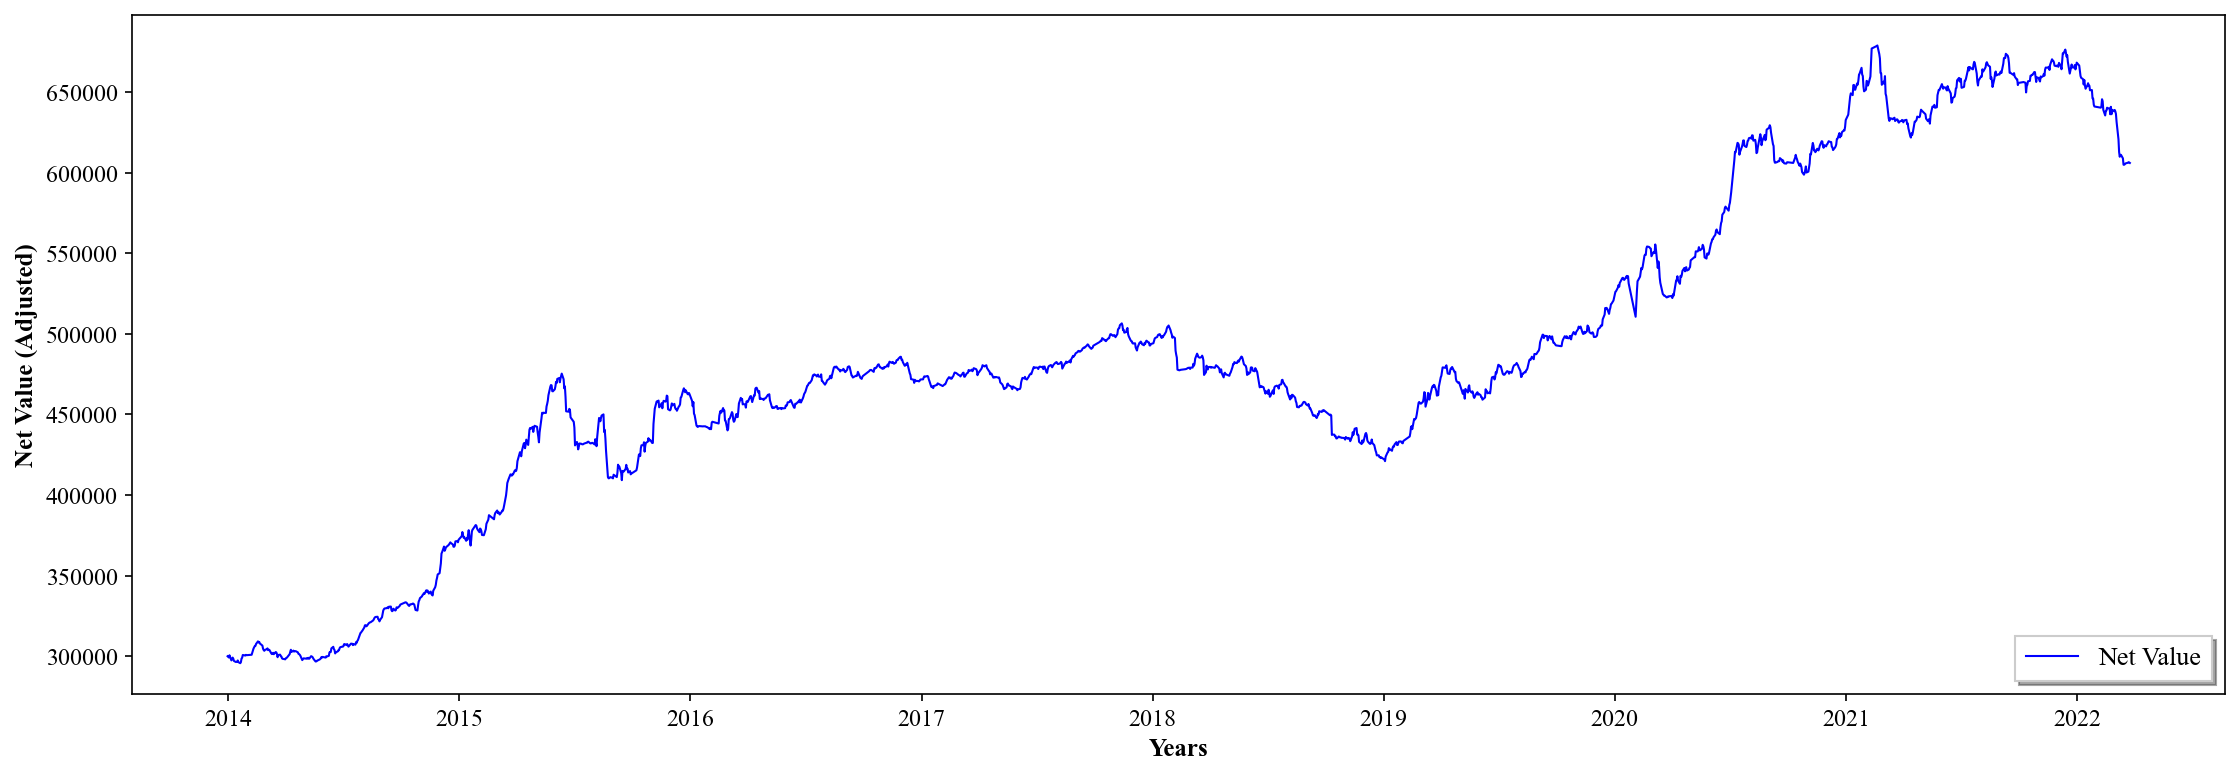

In [14]:
fig = plt.figure(figsize = (18,6),dpi = 150)
ax1 = fig.add_subplot(111)
ax1.plot(backtest_result.ACCOUNT_BALANCE, "-",color = "#0000FF",linewidth = 1,label = "Net Value")#非预测对比序列
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)
ax1.set_ylabel("Net Value (Adjusted)",fontsize = 12,weight = 'bold')
ax1.set_xlabel("Years",fontsize = 12,weight = 'bold')
ax1.legend(["Net Value"], loc = 'upper left',fontsize = 12.5,shadow = "gray",fancybox = False)

# ax2 = ax1.twinx()#真实指数序列
# plt.ylim(-0.15, 1)
# ax2.plot((position_holdings.sum(axis = 1).loc[start_date:]), "-",color = "orange",linewidth = 1,label = "Position Percentage")#非预测对比序列
# ax2.set_ylabel("Position",fontsize = 12,weight = 'bold')

plt.legend(loc = 'lower right',fontsize = 12.5,shadow = "gray",fancybox = False)
plt.savefig('./Plots/AccountBalance(Normal)',bbox_inches='tight')

In [15]:
# Sharpe
rf = 0.00011741094678452413
empyrical.sharpe_ratio(backtest_result.ACCOUNT_BALANCE.pct_change().dropna().values, risk_free = rf, period = 'daily', annualization = 365)

0.9790028528560987

In [16]:
# annual return
empyrical.annual_return(backtest_result.ACCOUNT_BALANCE.pct_change().dropna().values,period = 'daily',annualization = 365)

0.13662998083305888

In [17]:
# max drawdown
((backtest_result.ACCOUNT_BALANCE.cummax() - backtest_result.ACCOUNT_BALANCE)/(backtest_result.ACCOUNT_BALANCE.cummax())).max()

0.16876912326234222